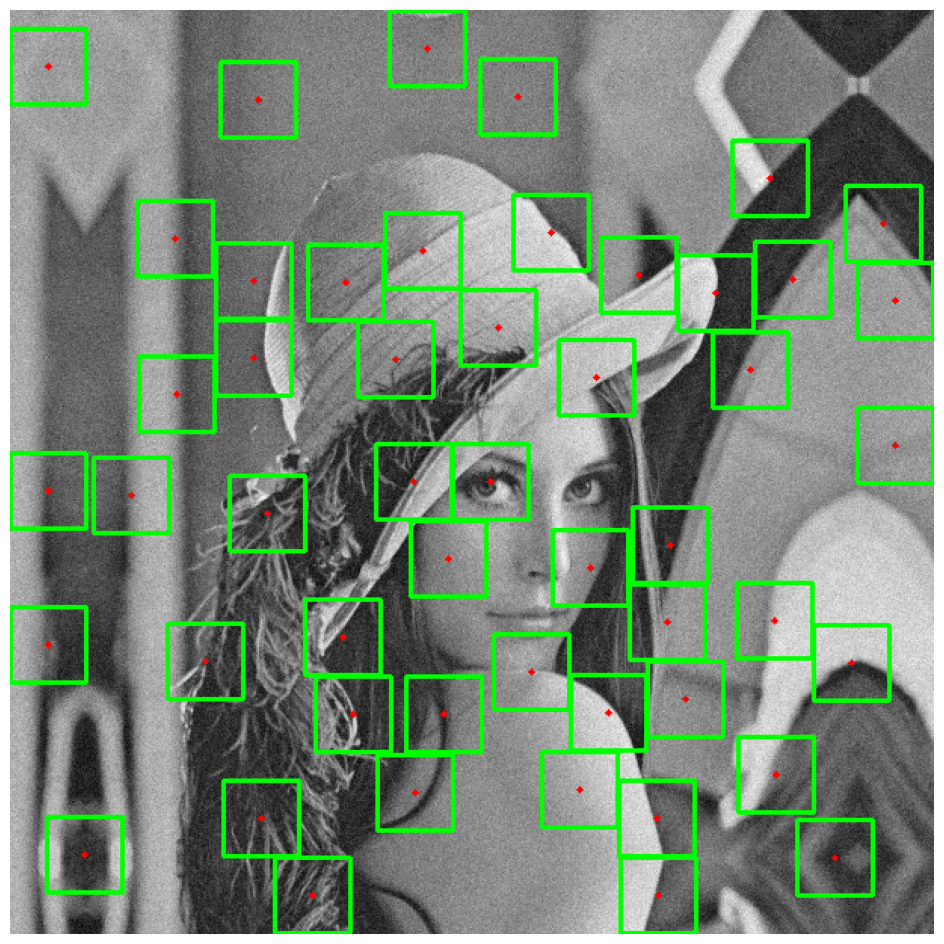

Sorted centers: [(166, 535), (578, 141), (273, 159), (227, 466), (384, 369), (557, 432), (506, 404), (161, 179), (25, 318), (255, 231), (80, 321), (447, 456), (318, 312), (129, 431), (170, 333), (161, 230), (377, 516), (287, 466), (428, 535), (388, 243), (336, 57), (586, 288), (268, 518), (164, 59), (220, 415), (222, 180), (437, 354), (358, 147), (416, 175), (200, 586), (503, 111), (429, 586), (110, 254), (276, 25), (109, 151), (435, 405), (267, 312), (396, 465), (467, 187), (546, 561), (323, 210), (518, 178), (290, 363), (507, 506), (586, 192), (345, 438), (25, 420), (49, 559), (25, 37), (490, 238)]


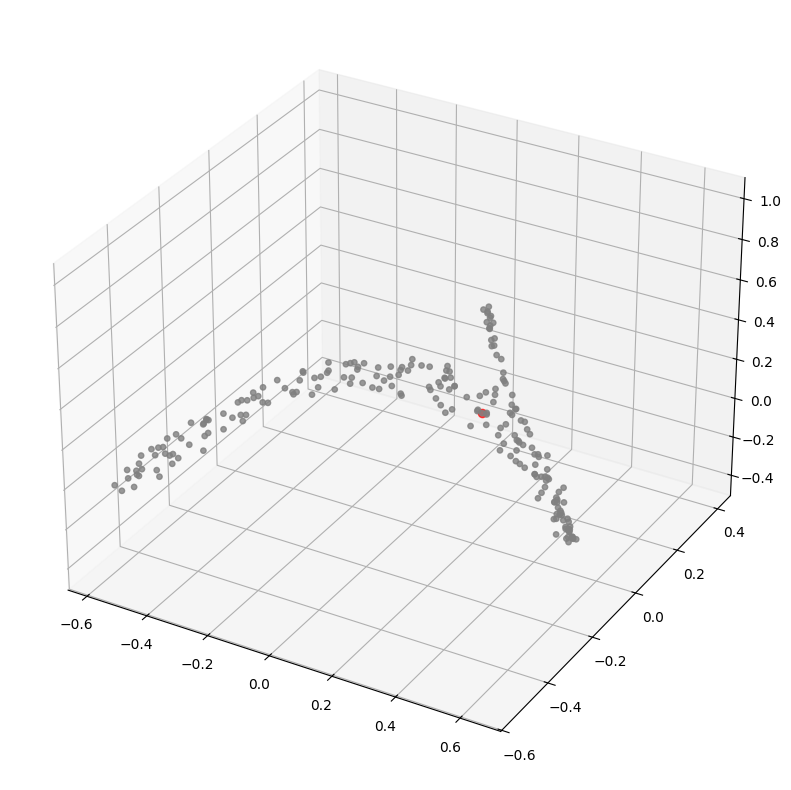

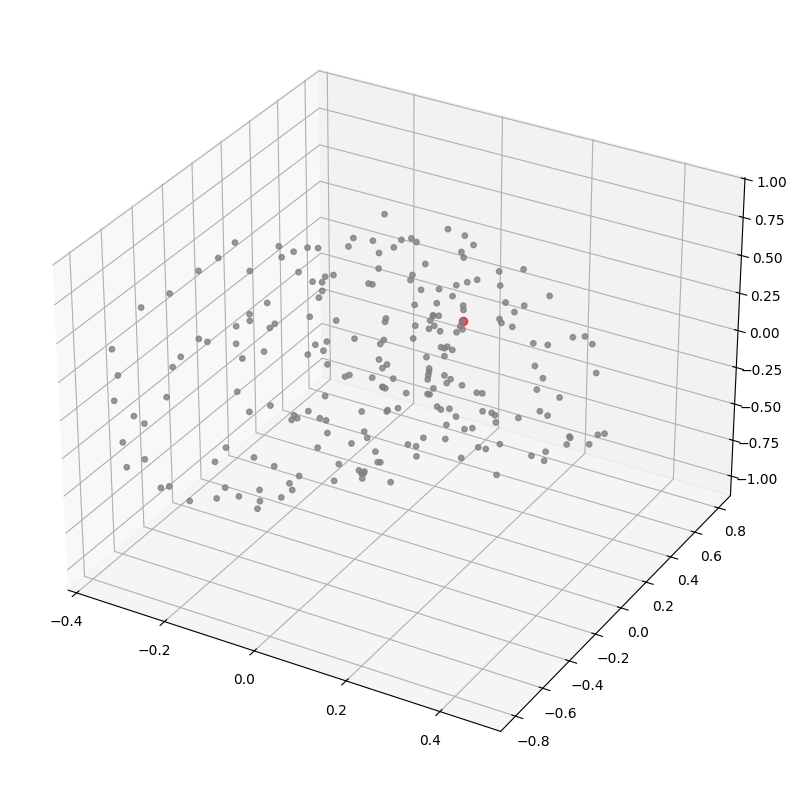

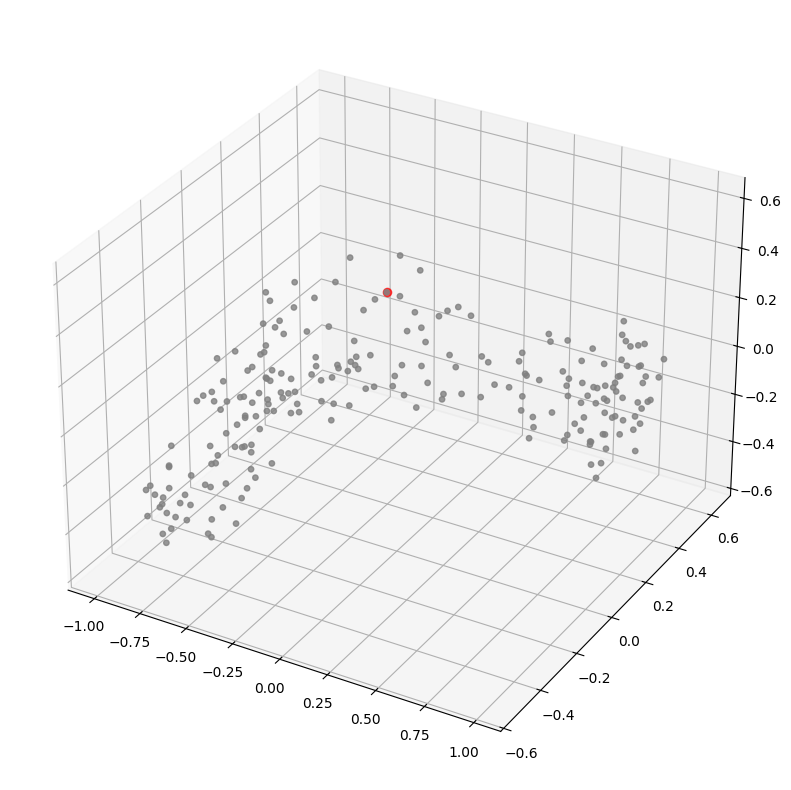

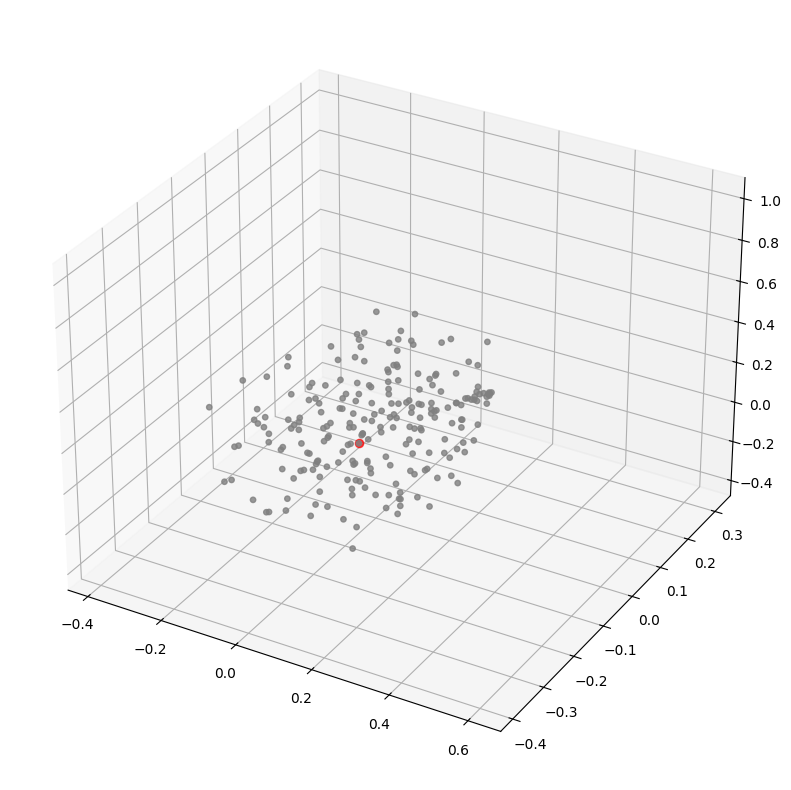

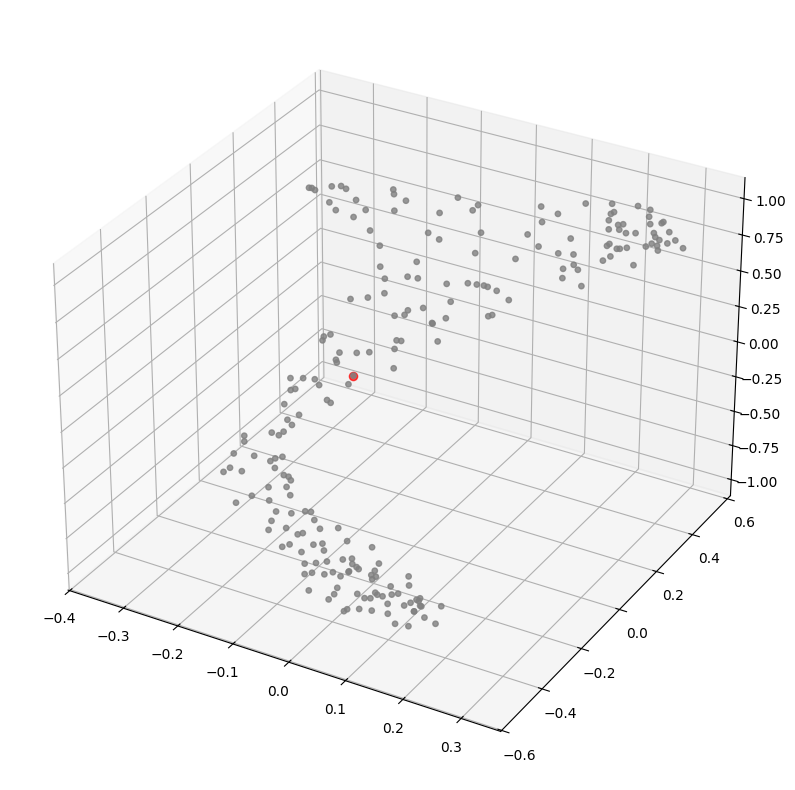

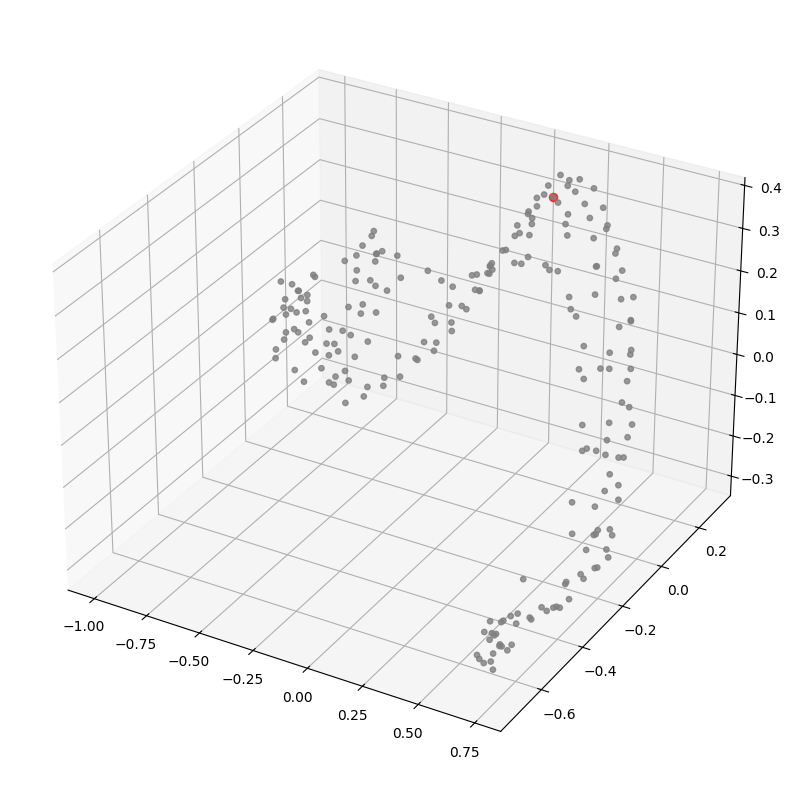

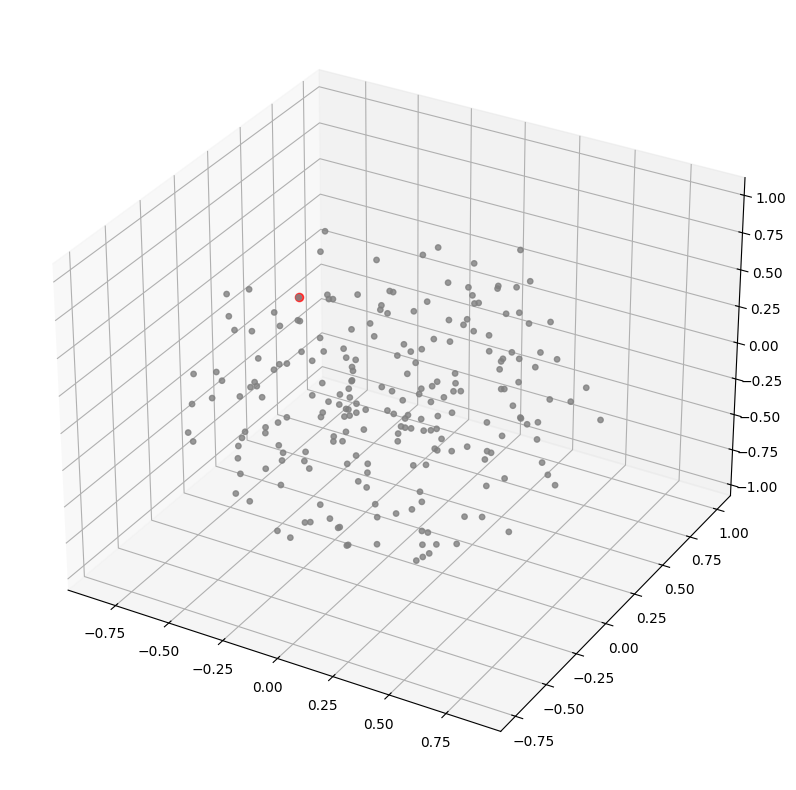

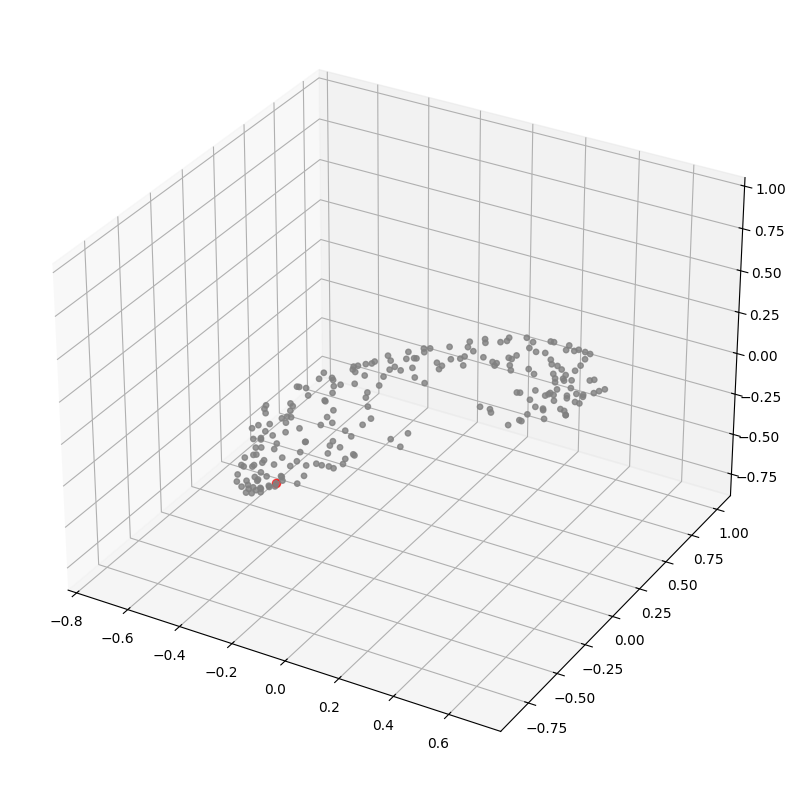

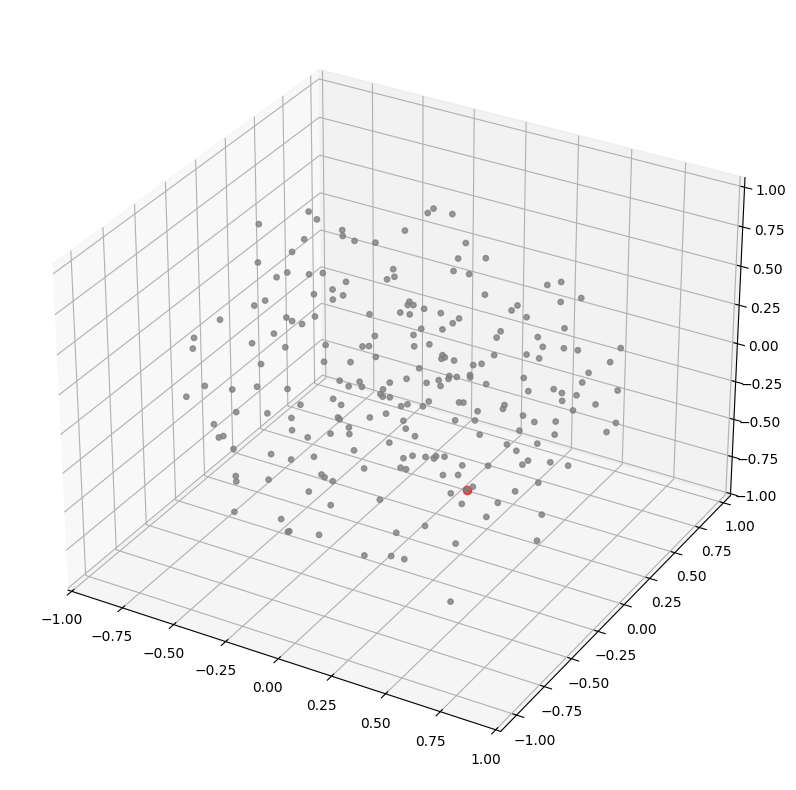

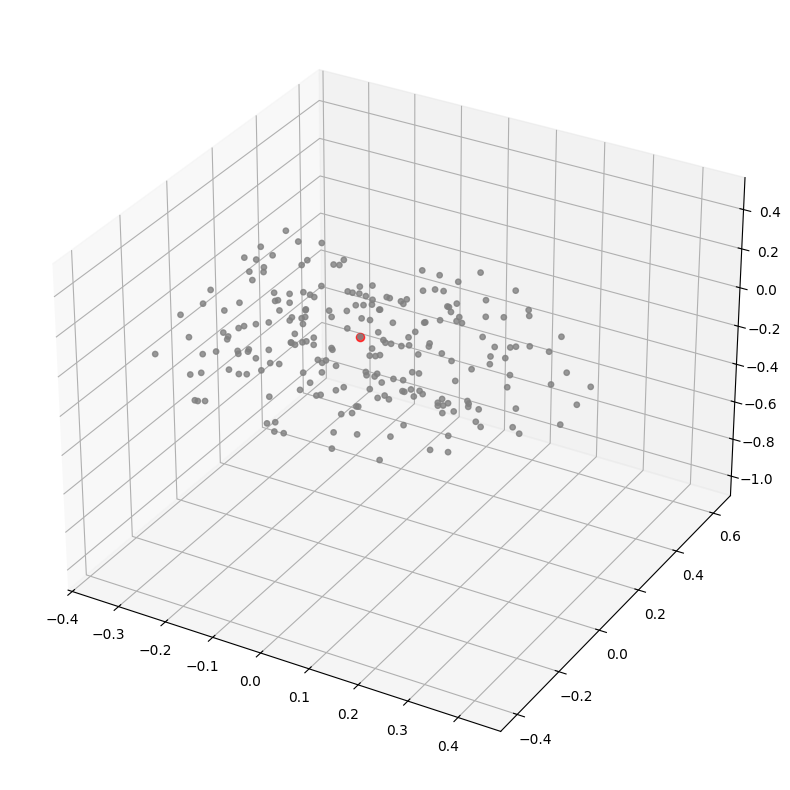

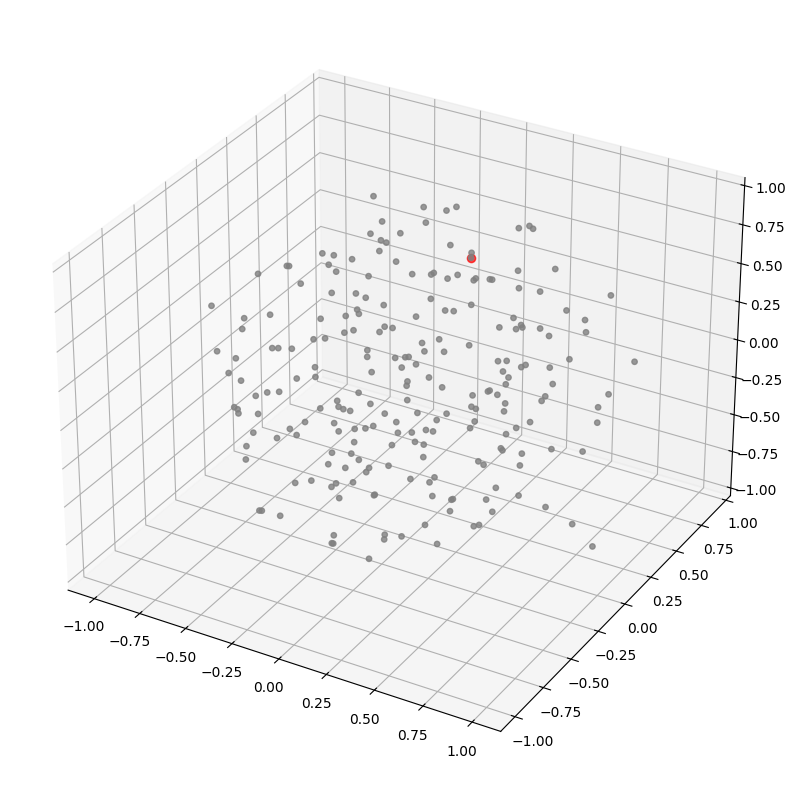

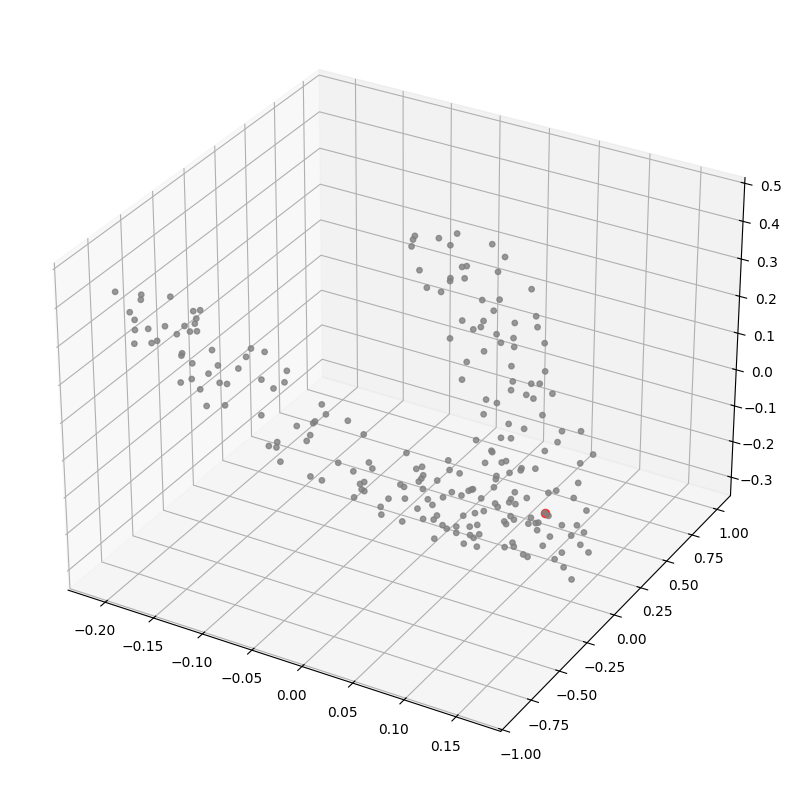

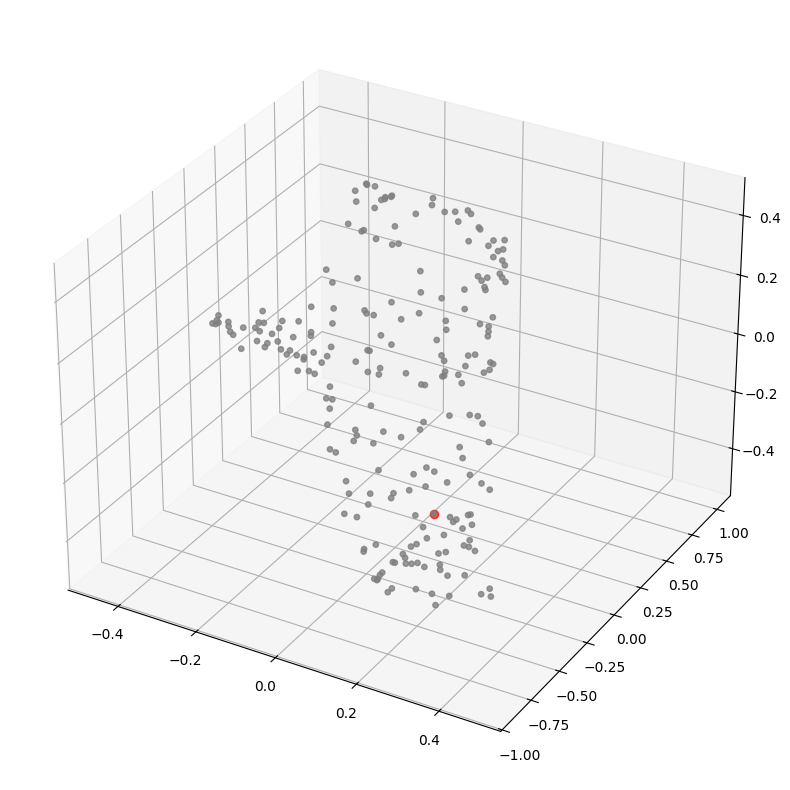

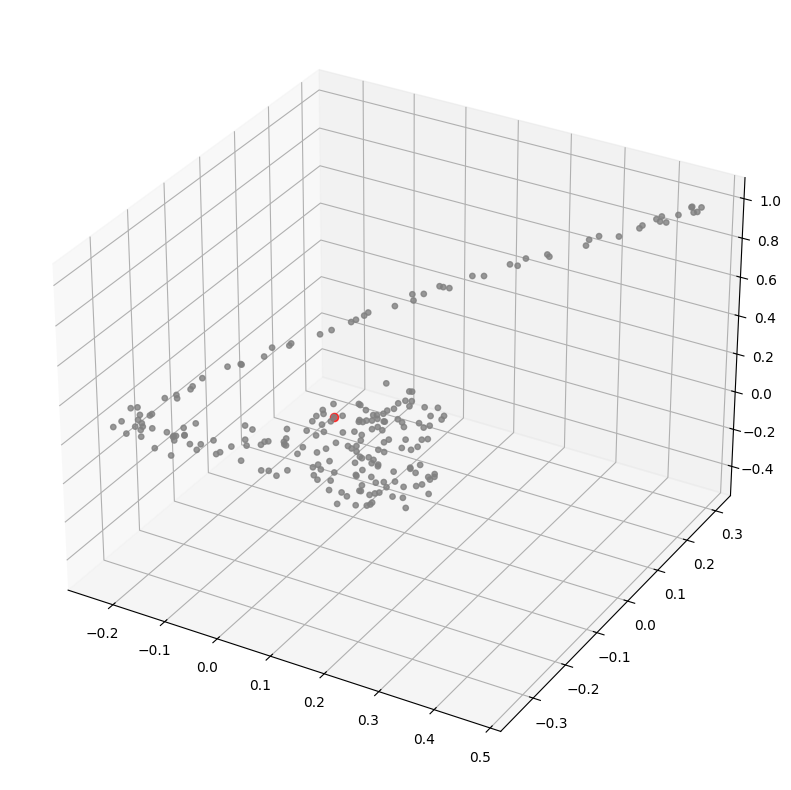

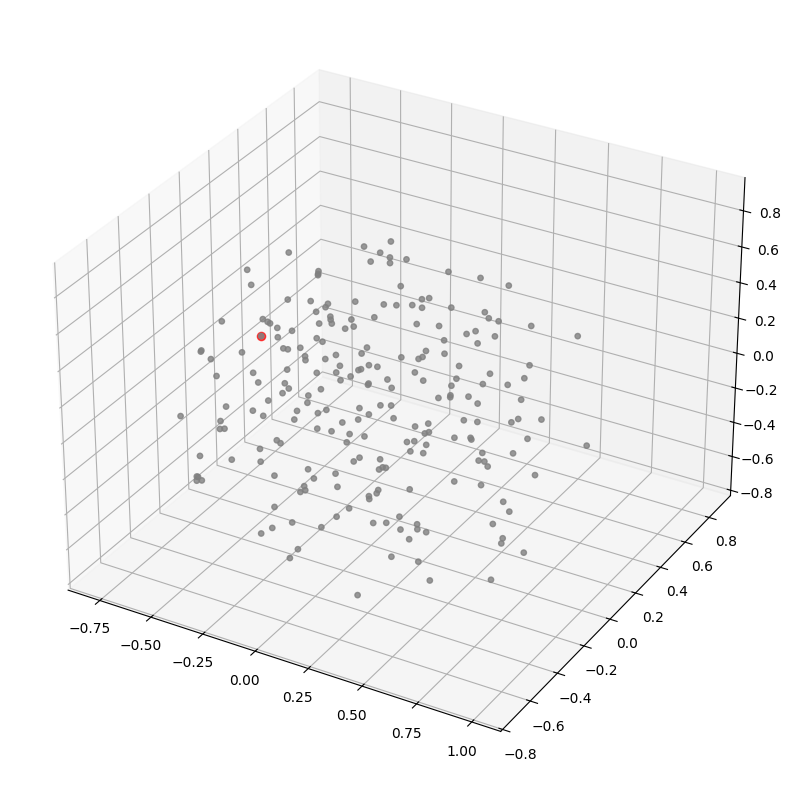

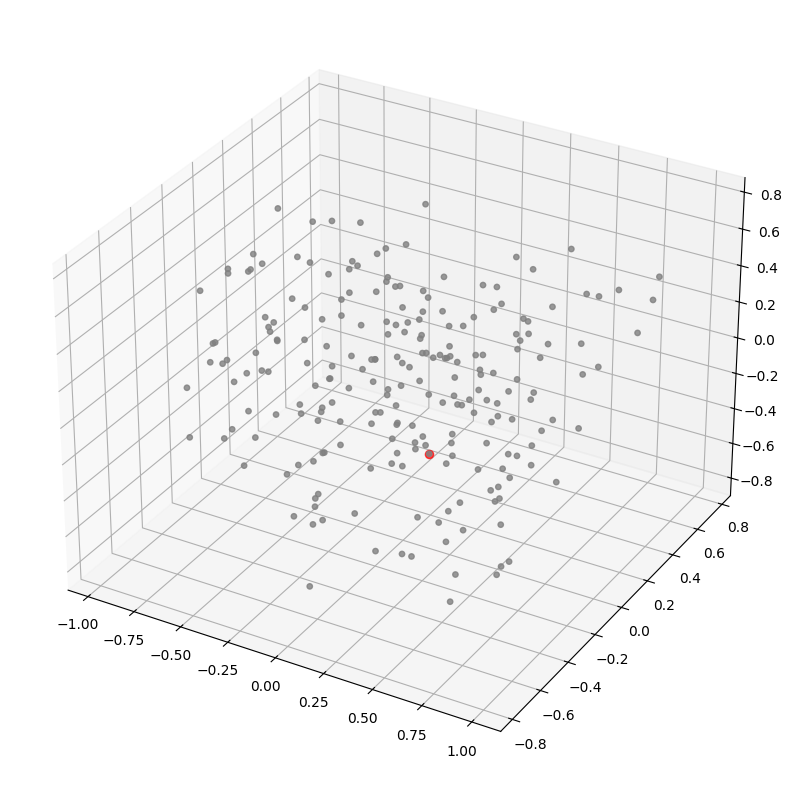

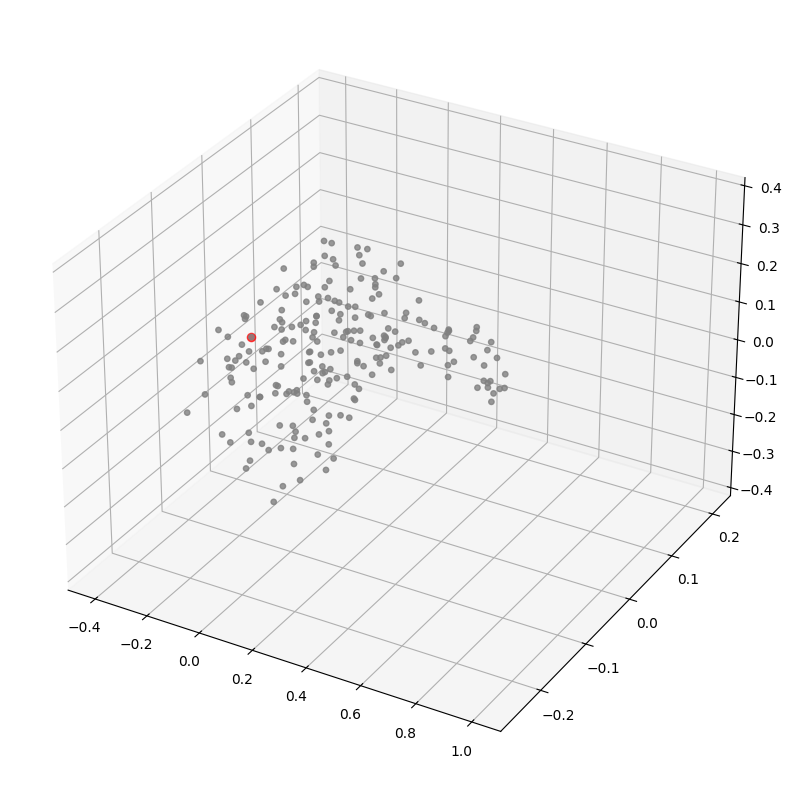

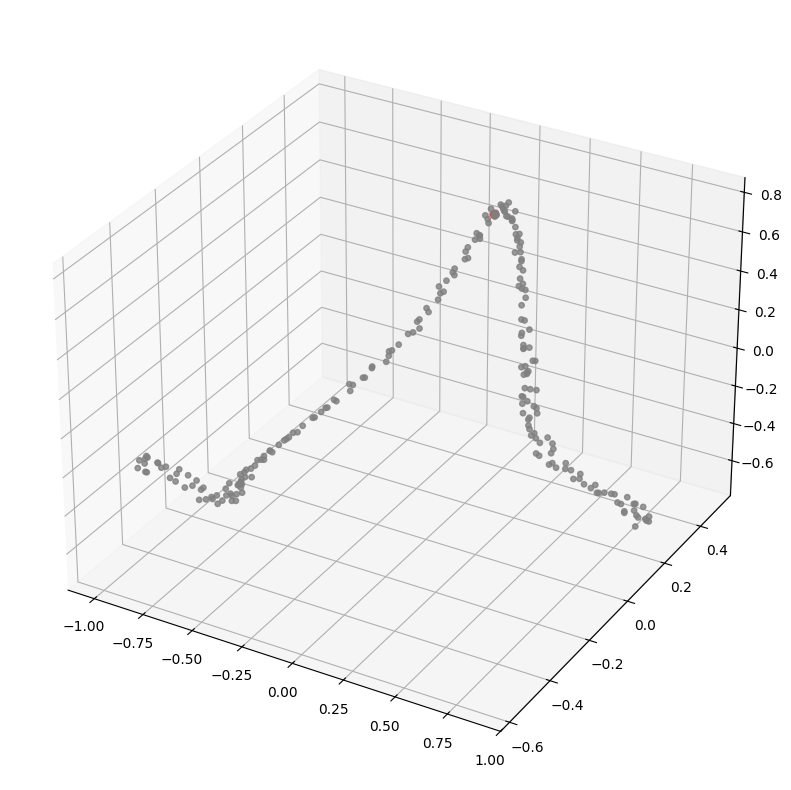

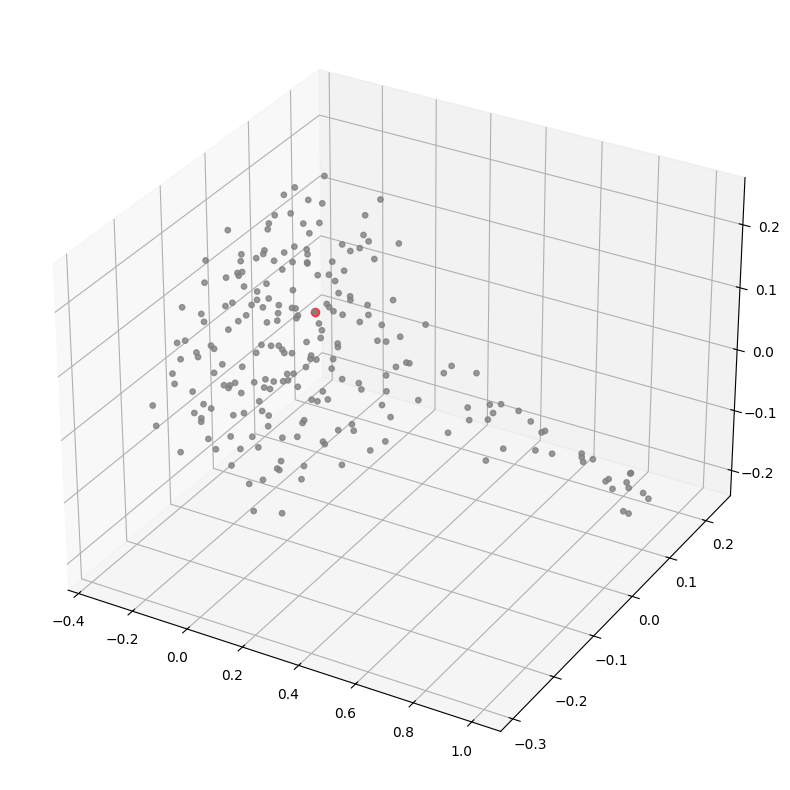

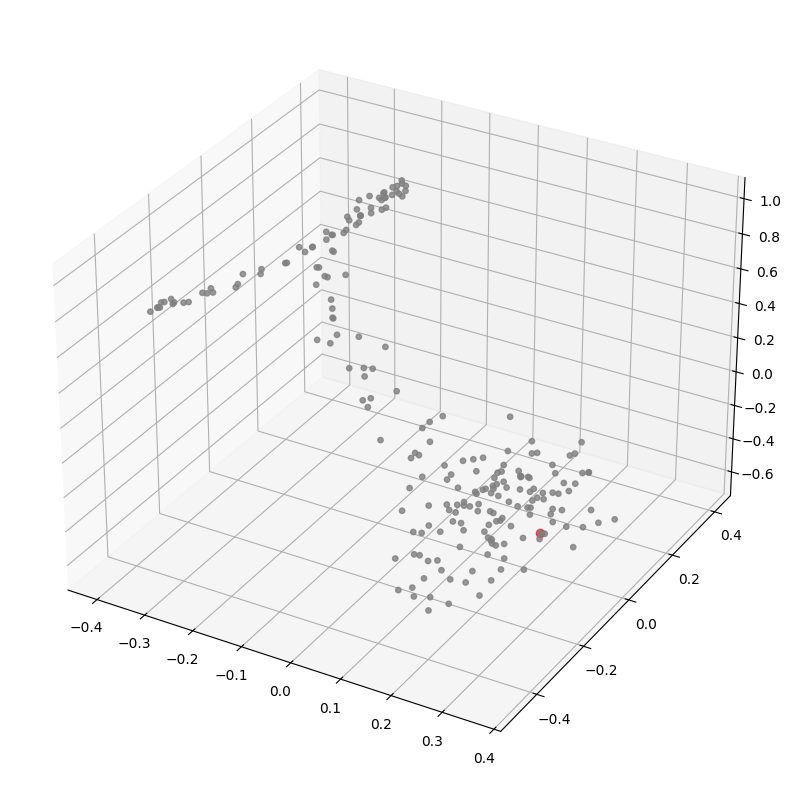

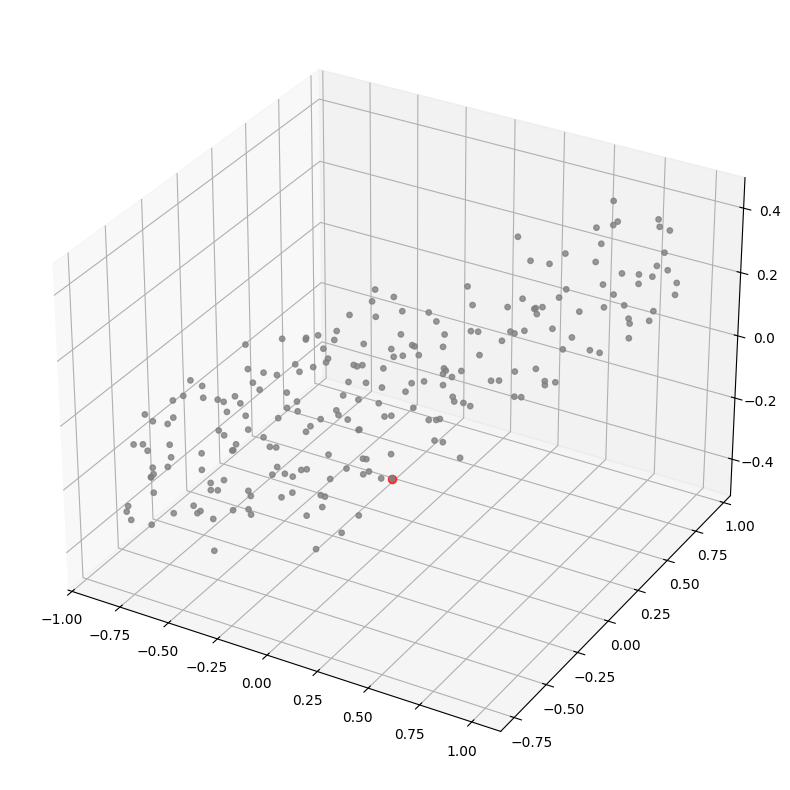

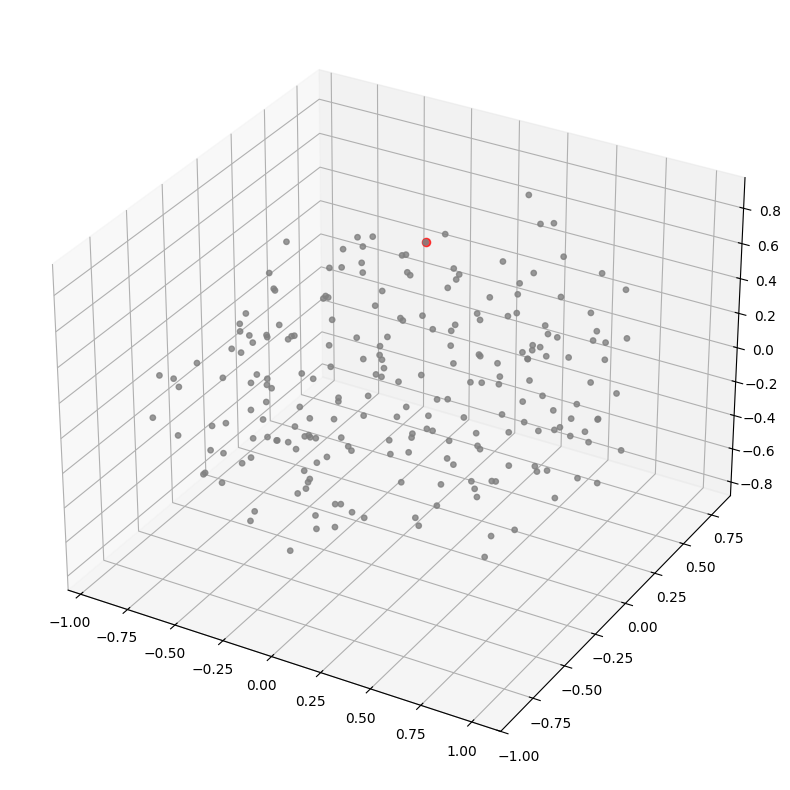

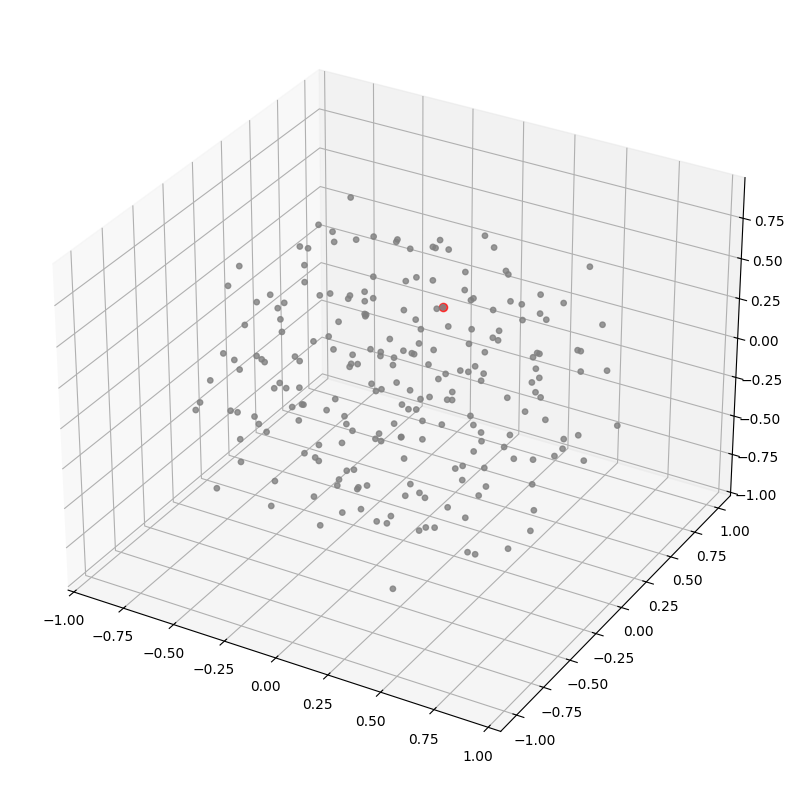

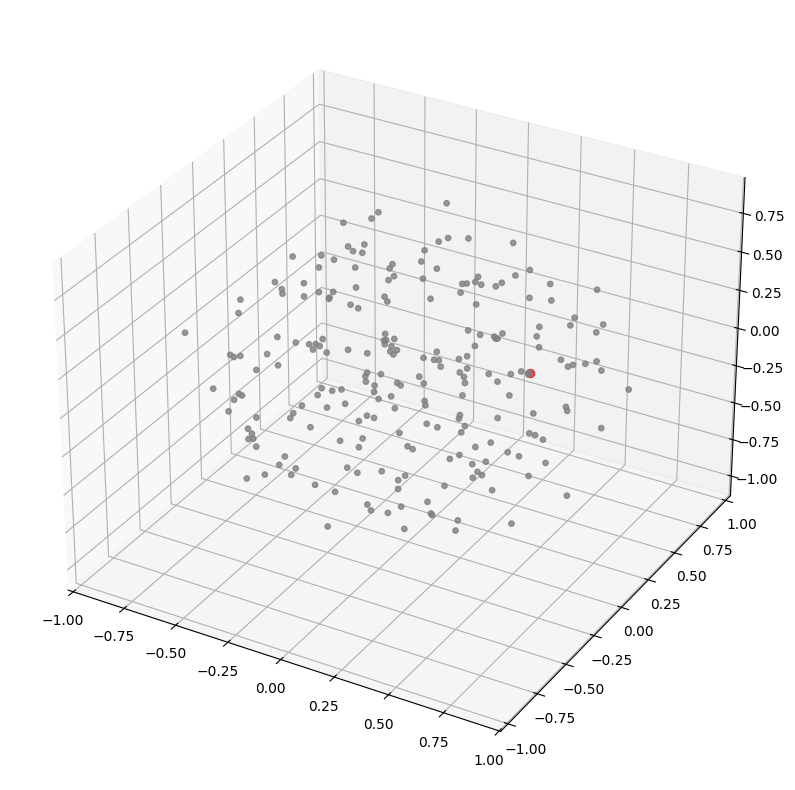

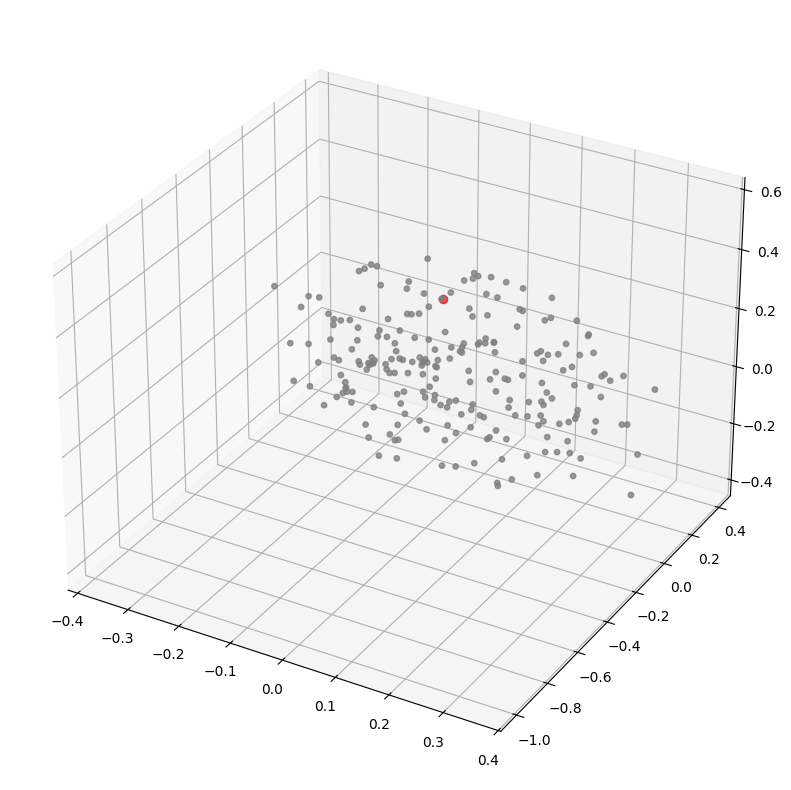

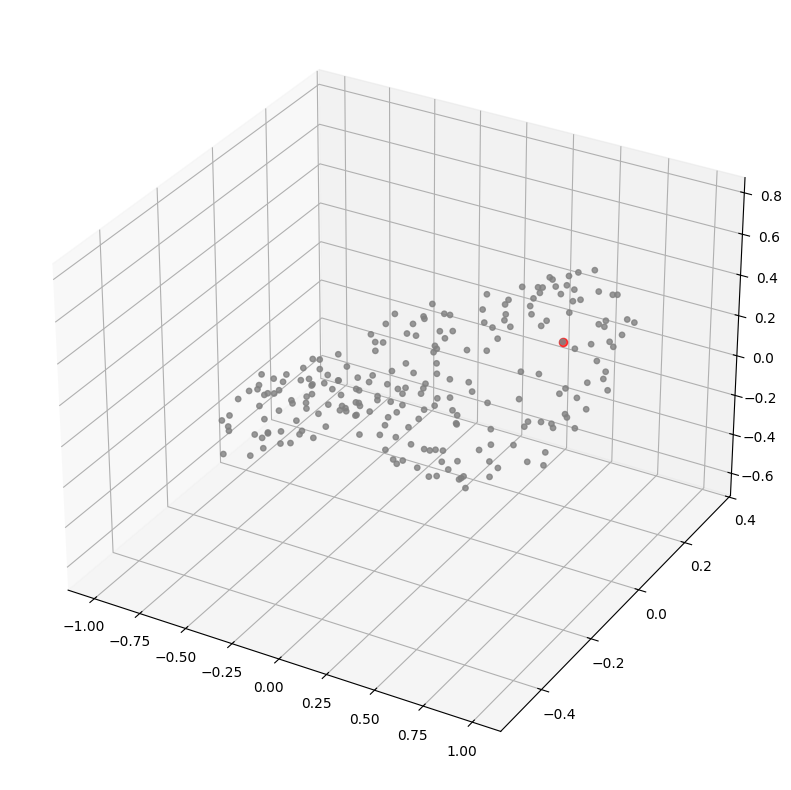

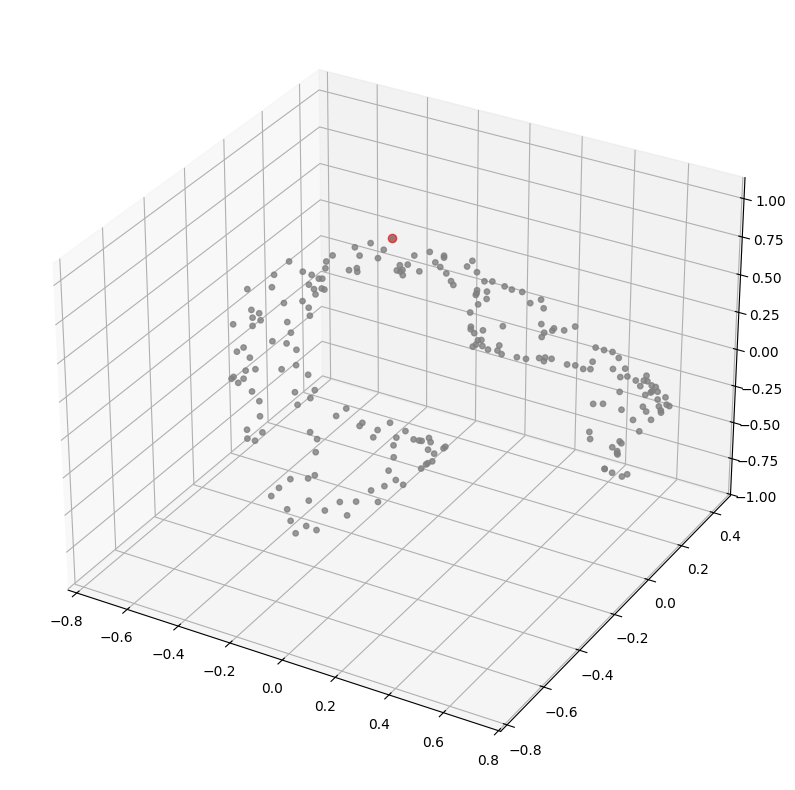

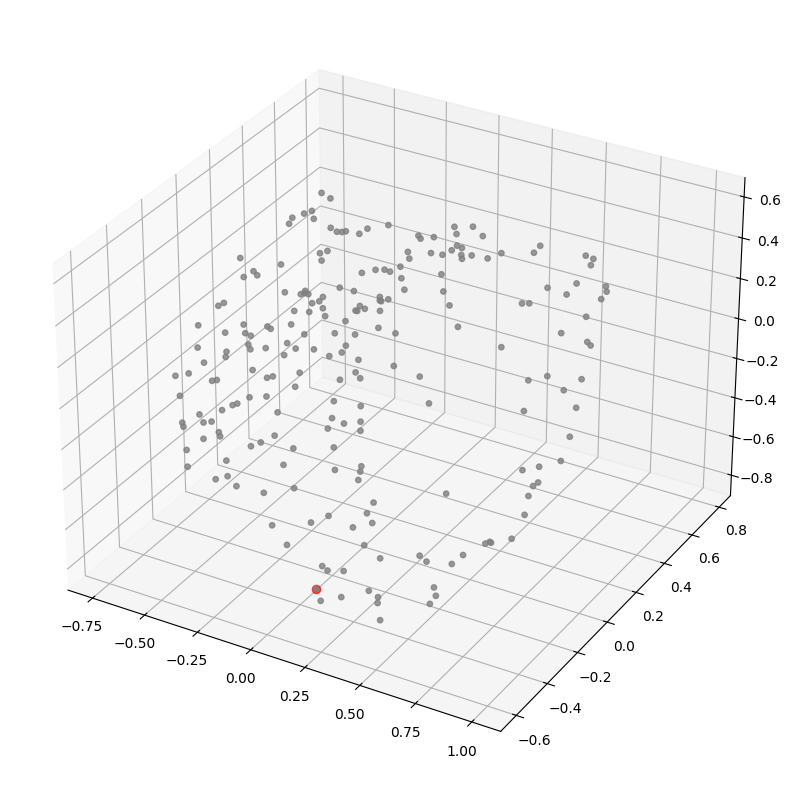

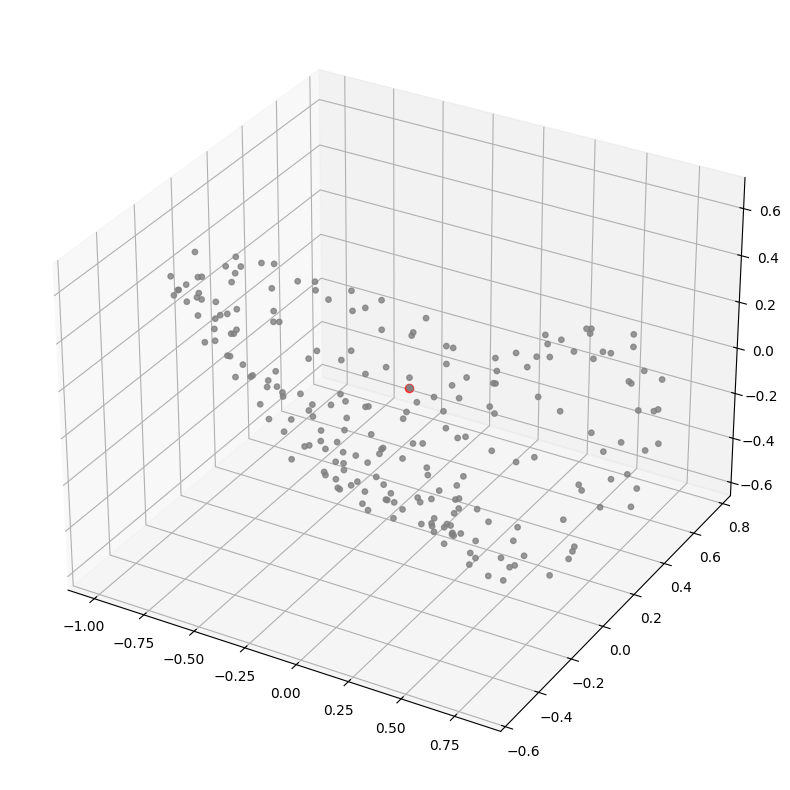

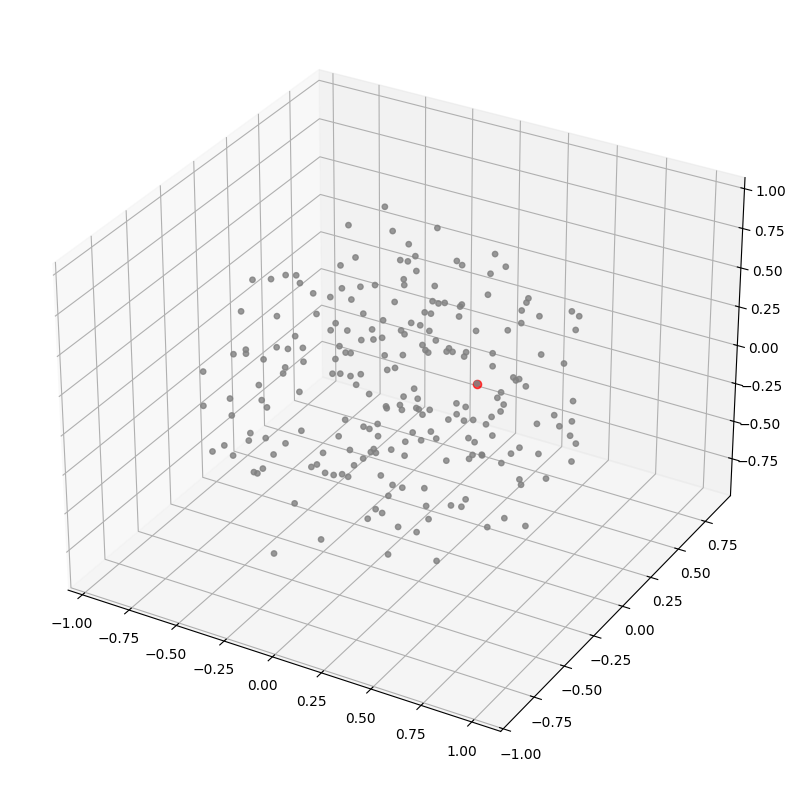

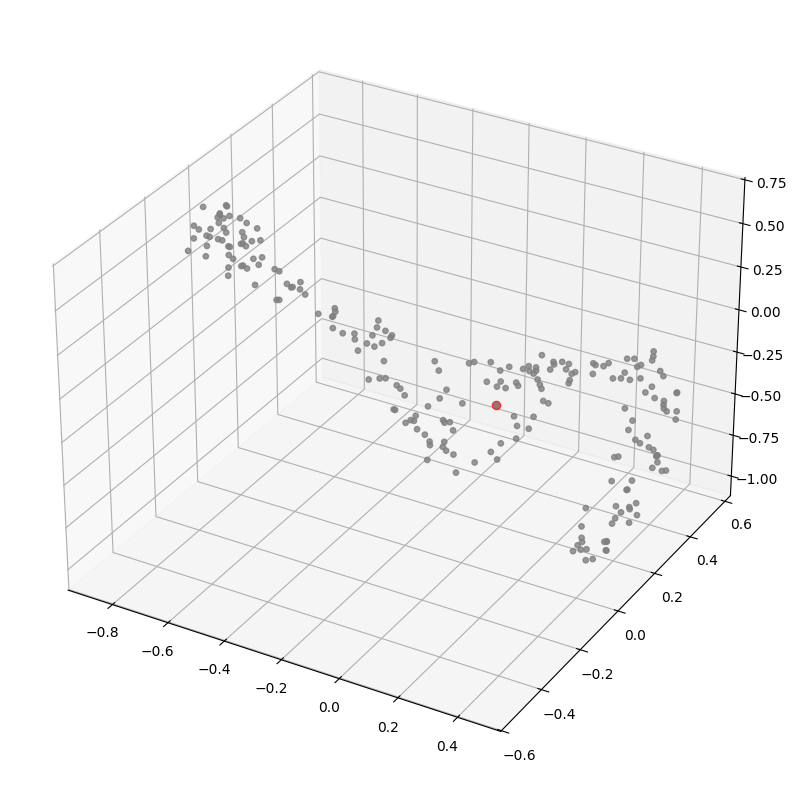

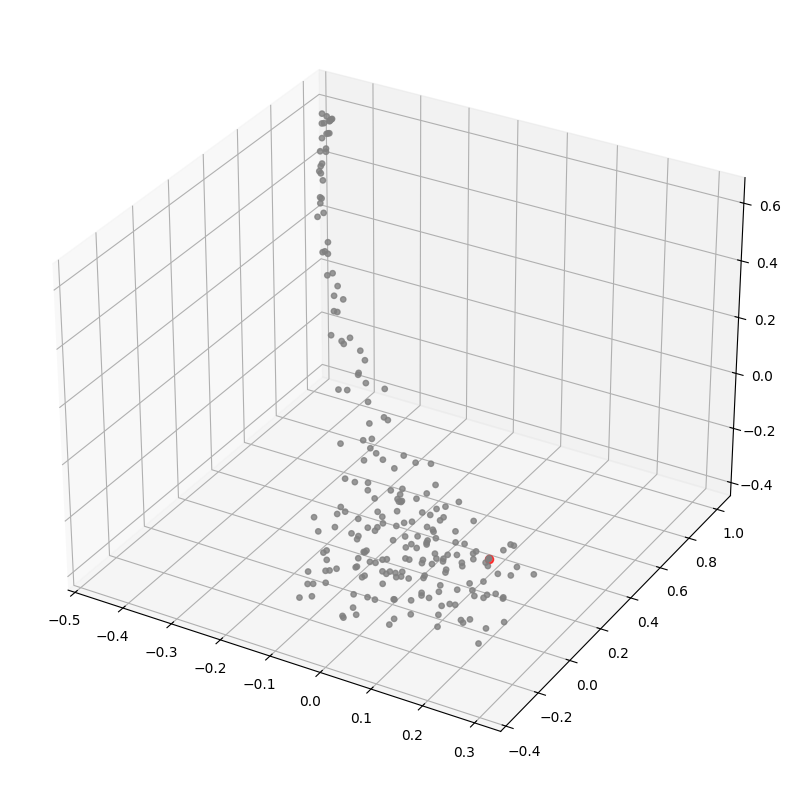

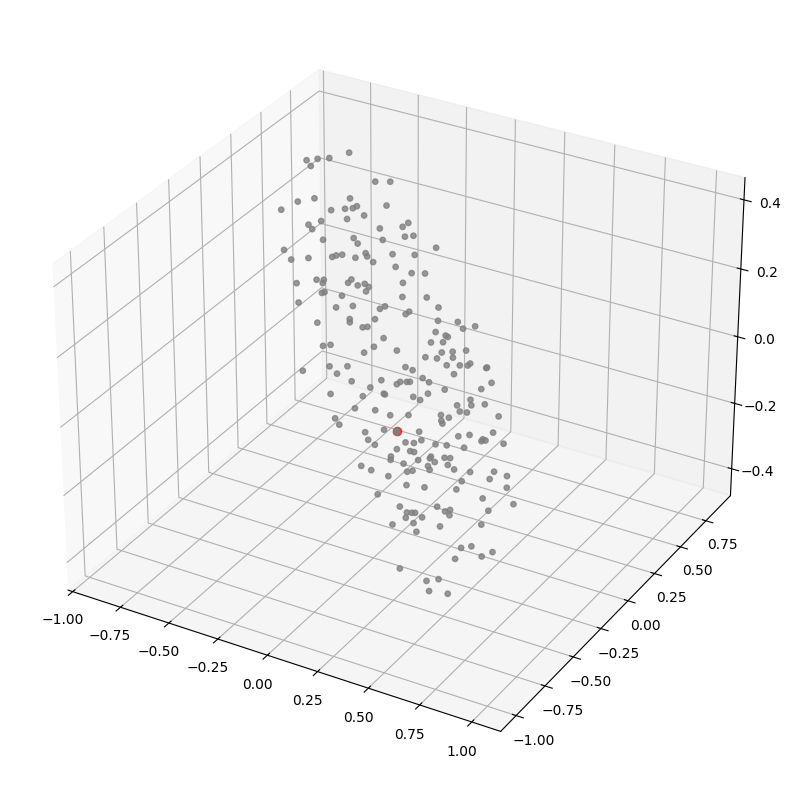

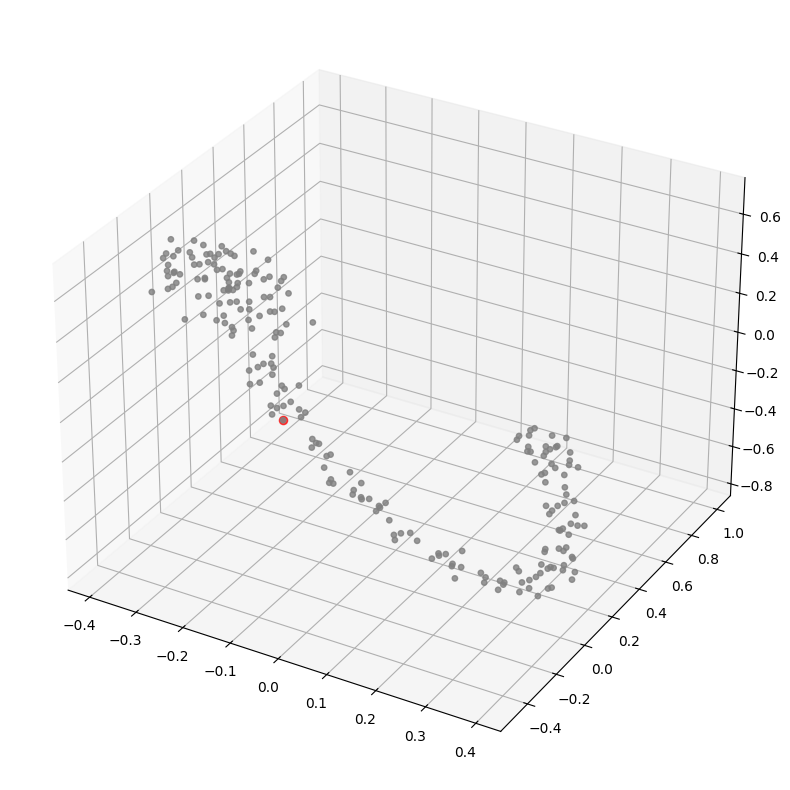

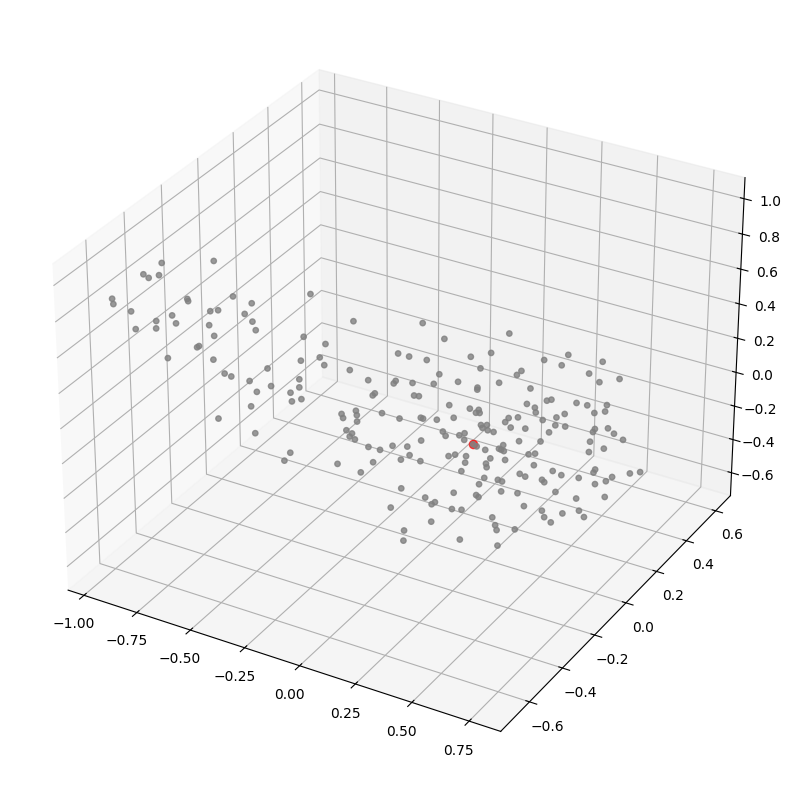

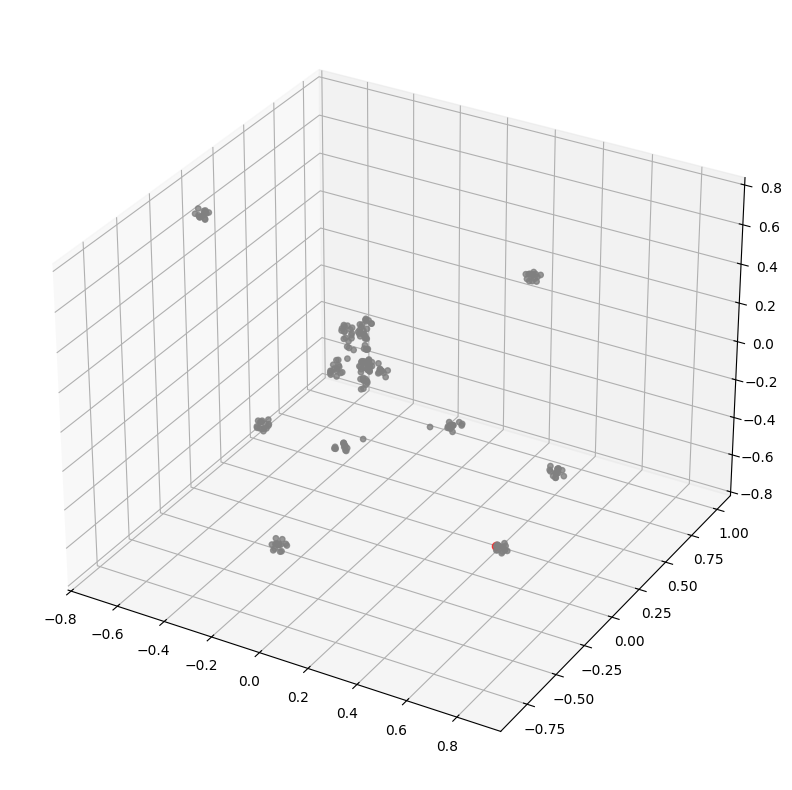

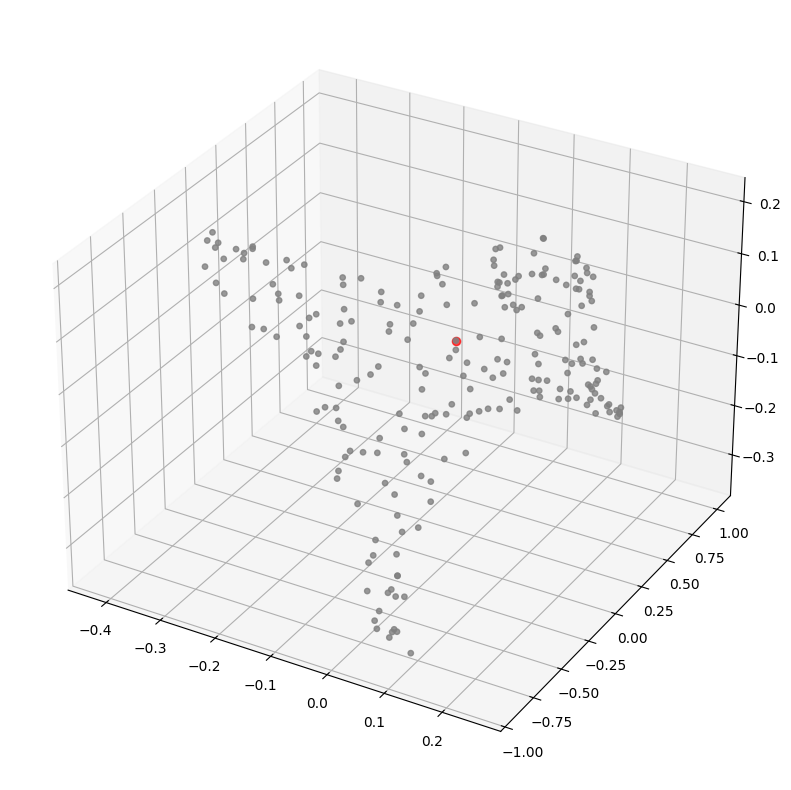

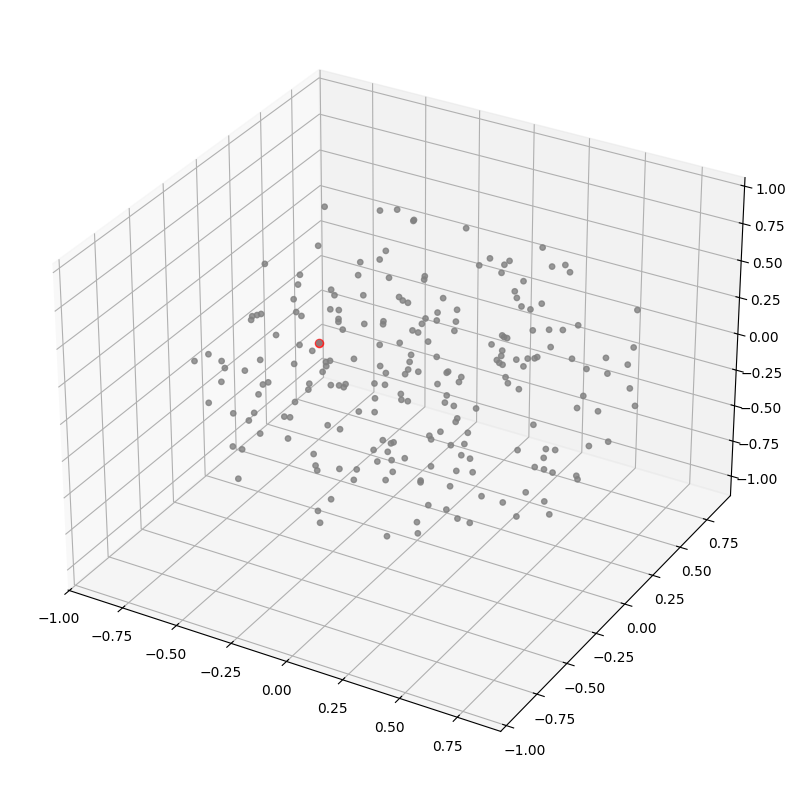

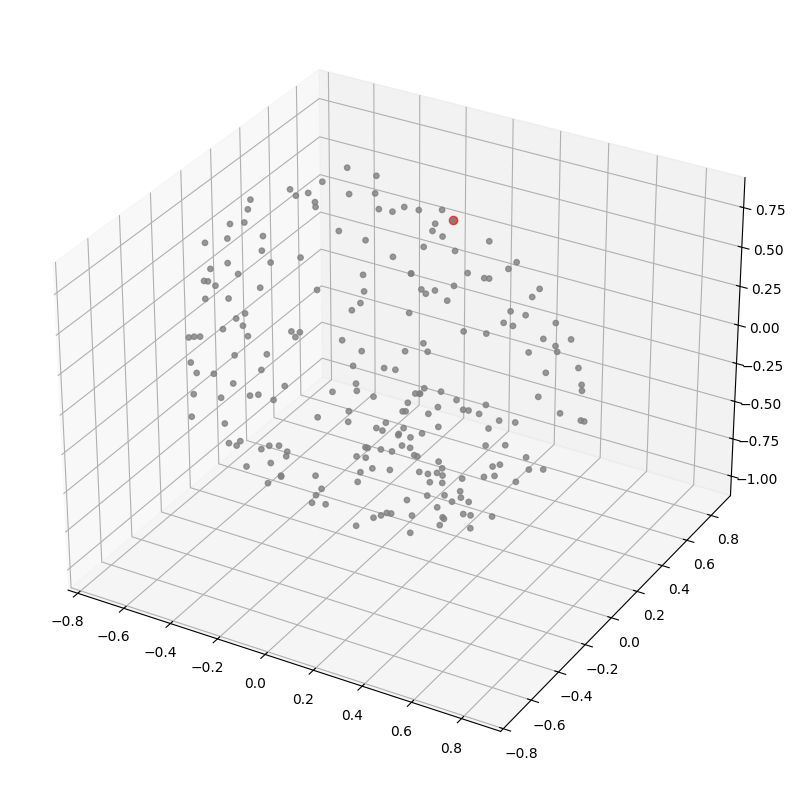

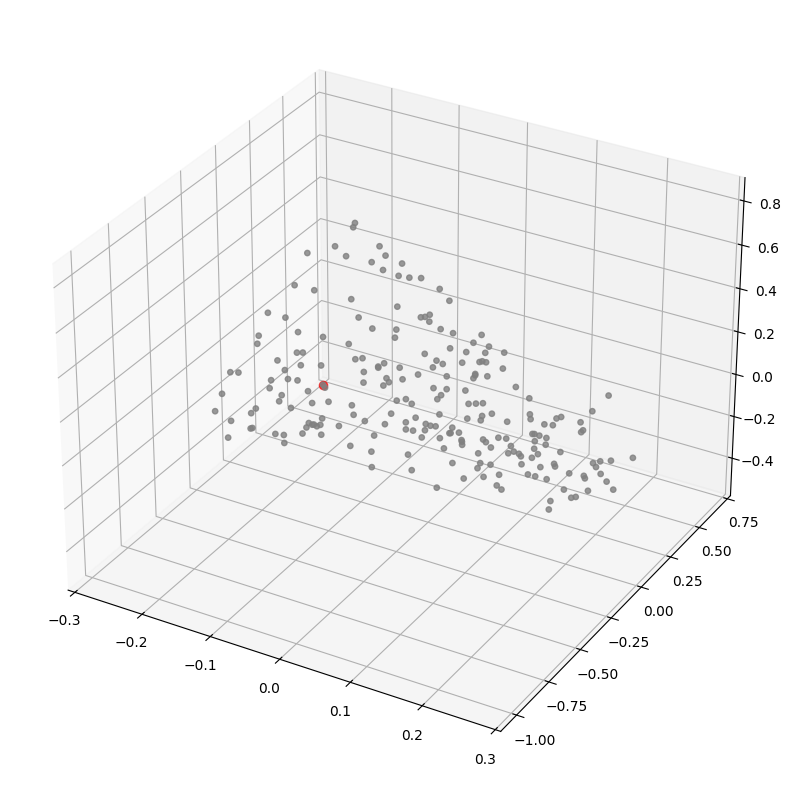

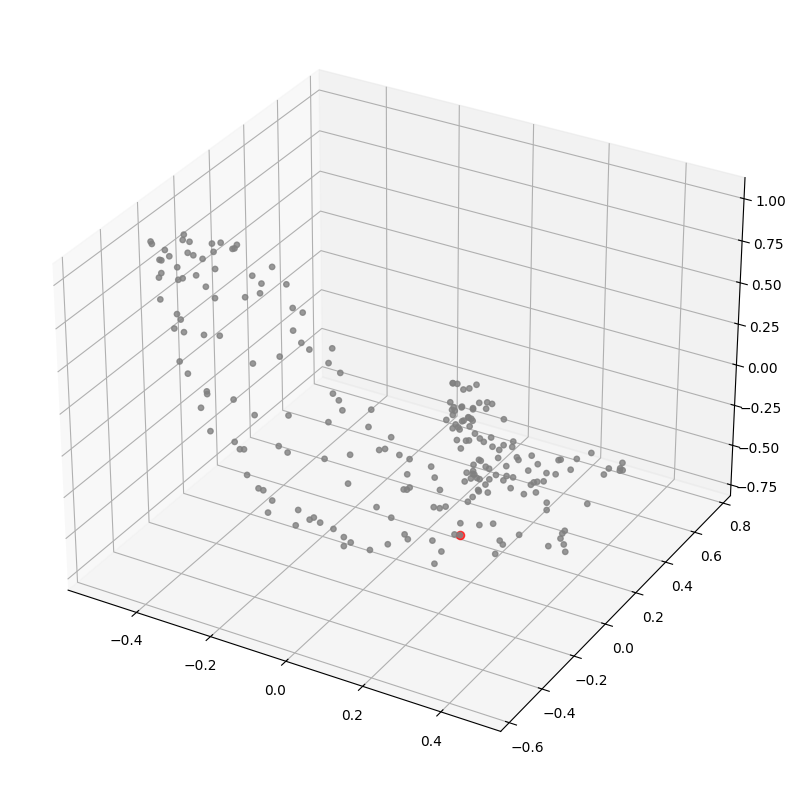

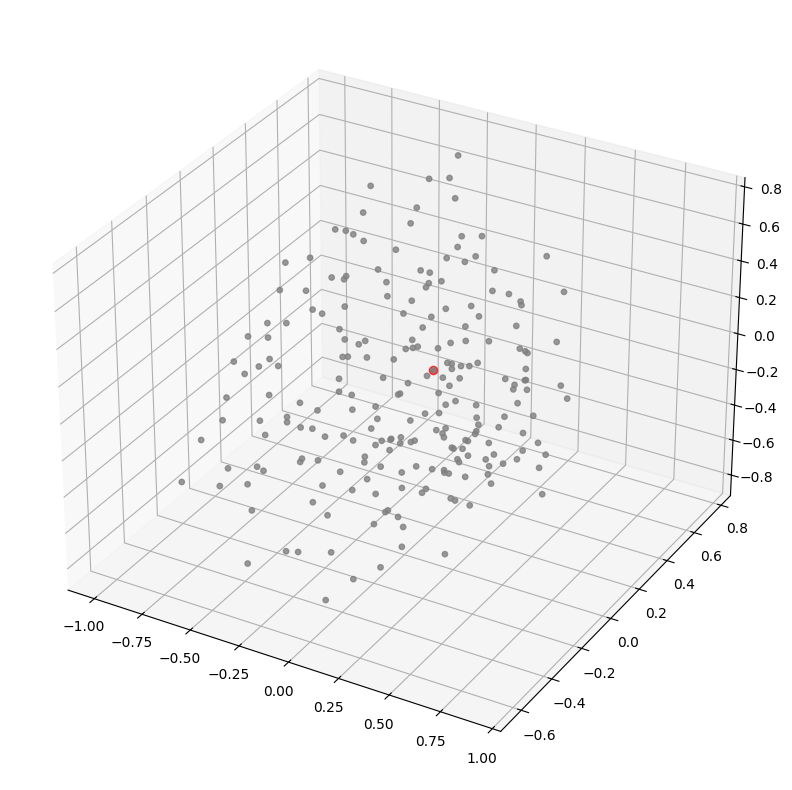

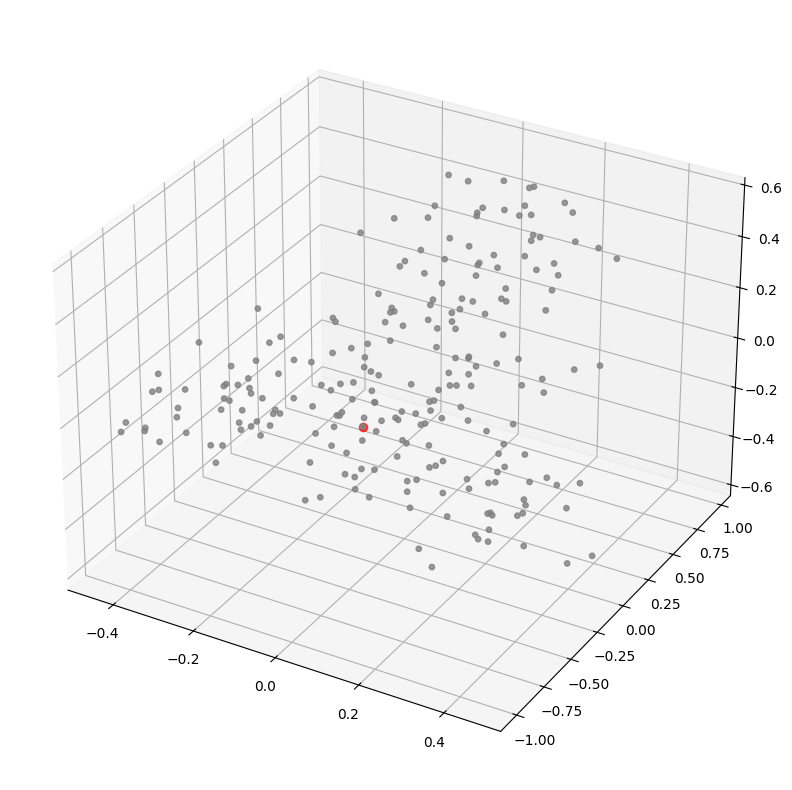

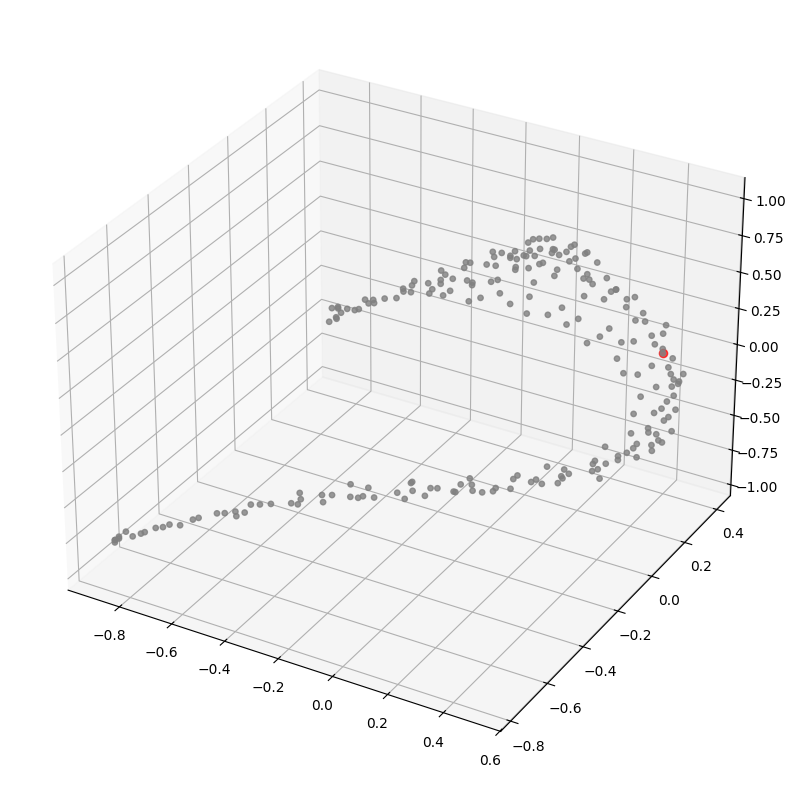

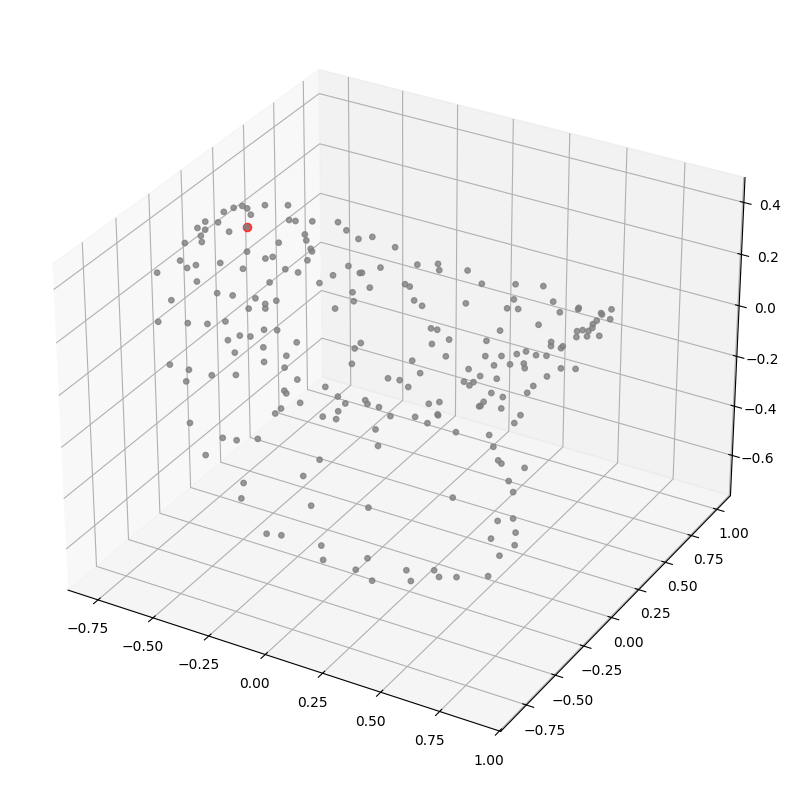

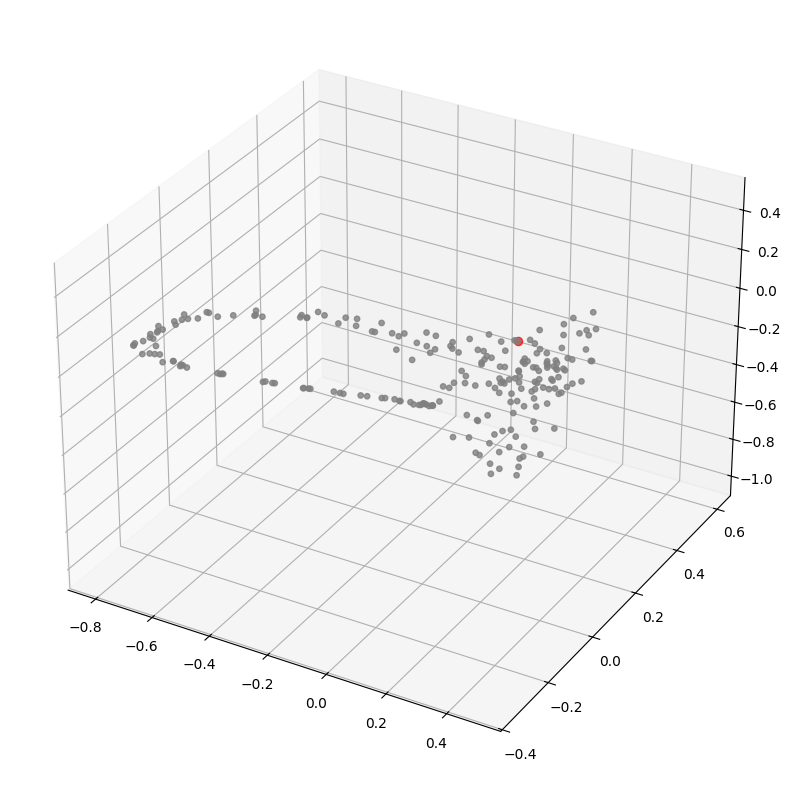

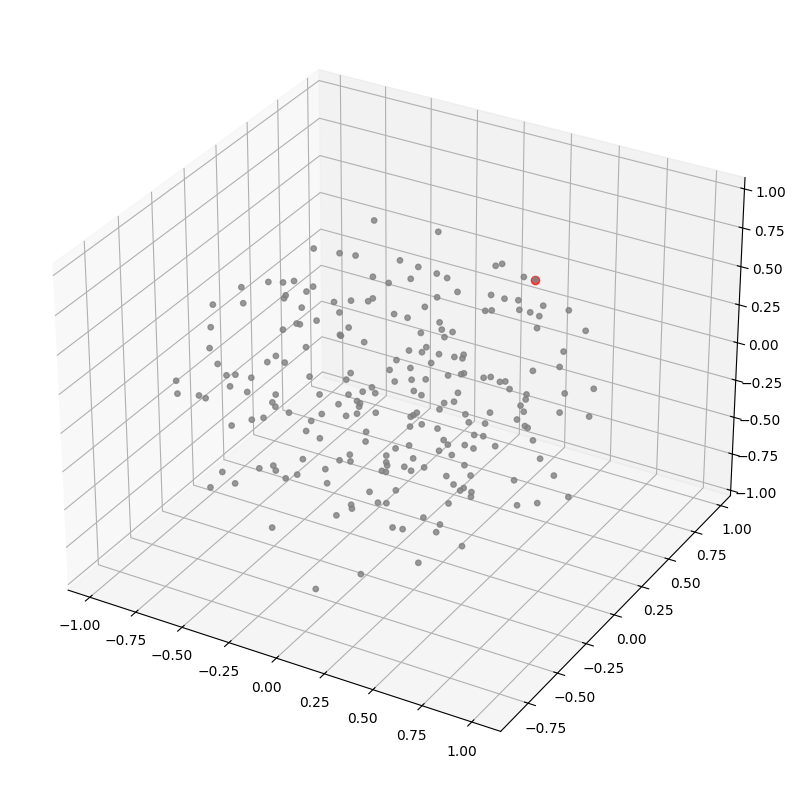

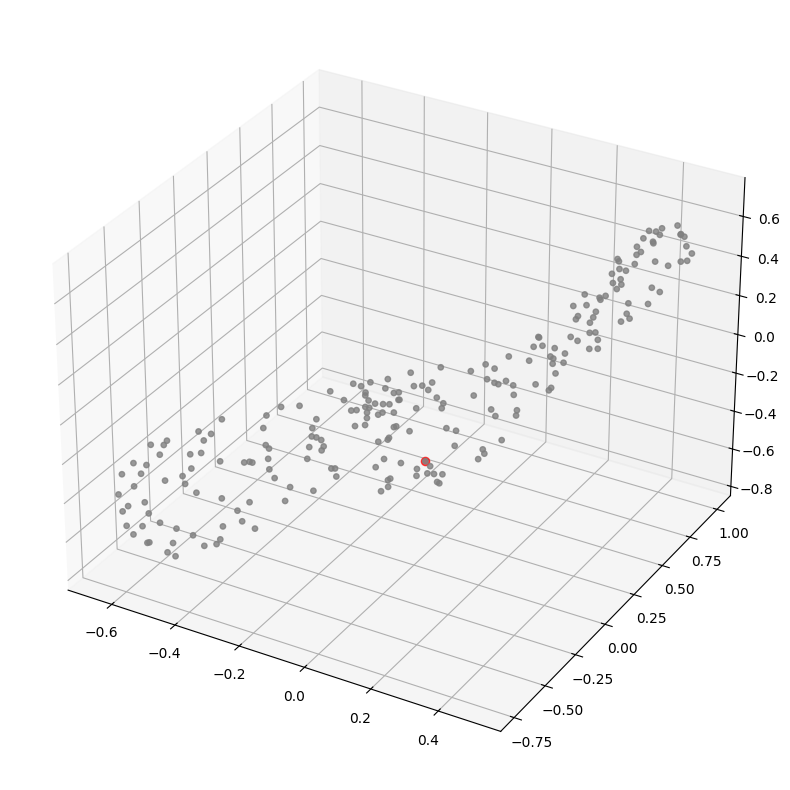

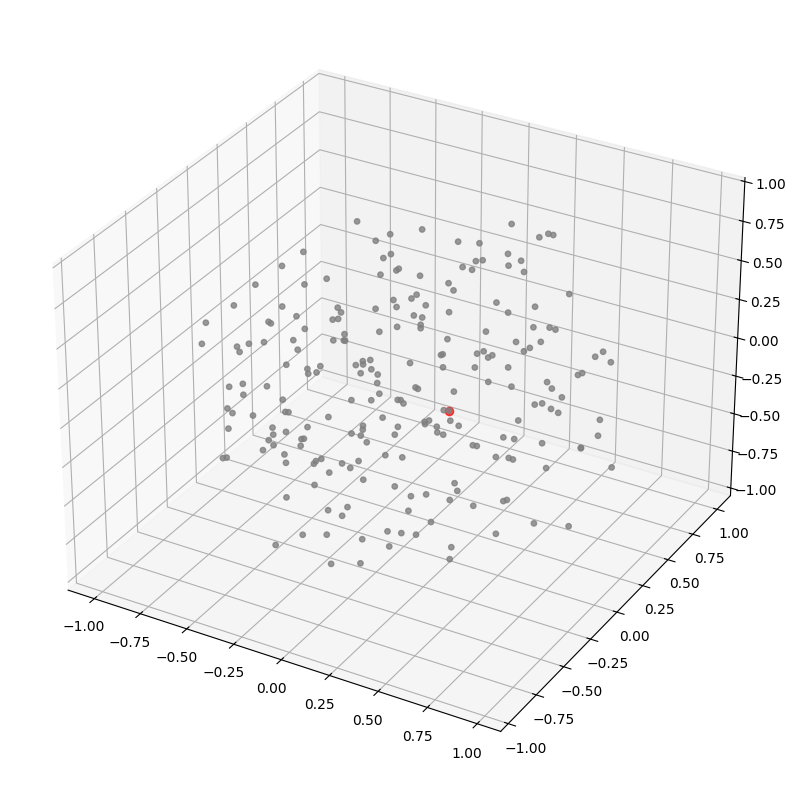

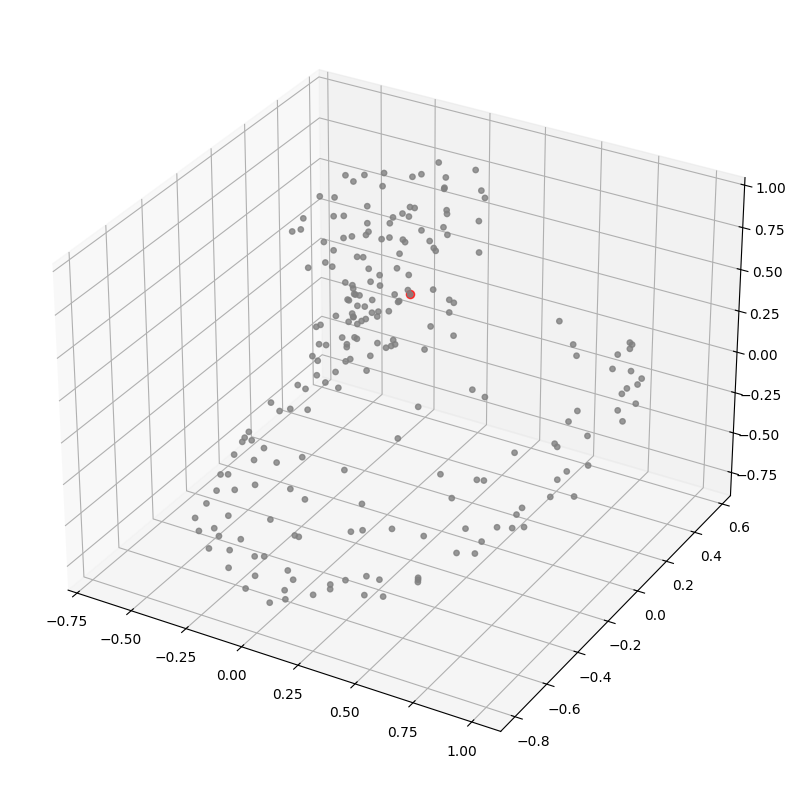

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 15 11:26:44 2019

Visualização dos patches ruidosos a partir do grafo k-NN

"""
import sys
import warnings
import time
import skimage
import statistics
import networkx as nx
import matplotlib.pyplot as plt
import skimage.io
import skimage.measure
import os

import umap
from numpy import eye
import sklearn.neighbors as sknn
from numba import njit   # just in time compiler (acelera loops)
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
import random

# Para evitar warning de divisão por zero
warnings.simplefilter(action='ignore')

'''
Espelhamento das bordas da imagem A de maneira simétrica
A função pad do numpy não é supertada pelo numba! (para acelerar com jit)
Substitui a função: img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')
f é o parâmetro (largura das bordas)
'''
@njit
def mirror(A, f):
    n = A.shape[0]
    m = A.shape[1]

    nlin = A.shape[0] + 2*f          # Altura da nova imagem com borda
    ncol = A.shape[1] + 2*f          # Largura da nova imagem com borda
    B = np.zeros((nlin, ncol))      # Inicializa matriz de saída com zeros

    B[f:nlin-f, f:ncol-f] = A       # Copia imagem original no centro

    # Preenche os quatro cantos com reflexão (espelhamento)
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])                          # 1o quadrante
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])                # 2o quadrante
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])                # 3o quadrante
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])      # 4o quadrante

     # Preenche as bordas (superior, inferior, esquerda, direita)
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])             # cima
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])   # baixo
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])             # esquerda
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])   # direita
    return B

'''
Extrai todos os patches em uma janela local centrada em (i, j)
f: metade do tamanho do patch
t: raio da janela de busca
'''
@njit
def Extract_patches_local(img, i, j, f, t):
    m, n = img.shape                             # Dimensões da imagem
    tamanho_patch = (2*f + 1)*(2*f + 1)          # Tamanho do vetor de um patch

    img_n = mirror(img, f)                       # Adiciona borda espelhada

    im = i + f;                                  # Compensação por causa do padding
    jn = j + f;

    patch_central = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1].copy()      # Patch central
    central = patch_central.reshape((1, patch_central.shape[0]*patch_central.shape[1]))[-1]

    # Limites da janela de busca
    rmin = max(im-t, f)
    rmax = min(im+t, m+f)
    smin = max(jn-t, f)
    smax = min(jn+t, n+f)

    num_elem = (rmax - rmin + 1)*(smax - smin + 1)  # Total de patches na janela

    dataset = np.zeros((num_elem, tamanho_patch))  # Inicializa matriz de patches
    k = 0                                           # Índice do patch atual no dataset

    for r in range(rmin, rmax+1):
        for s in range(smin, smax+1):
            W = img_n[r-f:(r+f)+1, s-f:(s+f)+1].copy()  # Extrai patch da posição atual
            neighbor = W.reshape((1, W.shape[0]*W.shape[1]))[-1]  # Transforma em vetor
            dataset[k, :] = neighbor.copy()              # Adiciona ao dataset

            if (central == neighbor).all():              # Salva índice do patch central
                source = k

            k = k + 1

    return dataset, source   # Retorna todos os patches da janela e o índice do patch central

'''
Constrói o grafo k-NN a partir de uma matriz de dados (n amostras x m features)
'''
def build_KNN_Graph(dados, k):
    KNNG = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')  # Grafo de k-vizinhos com pesos = distâncias
    G = nx.from_scipy_sparse_array(KNNG)  # Converte o grafo para formato NetworkX
    return G

def get_umap_embedding(data, n_components=3, random_state=42):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    embedding = reducer.fit_transform(data)
    return embedding

'''
Plota um grafo NetworkX com destaque para um nó central
layout: 'kamada' ou outro (default = spring)
plot_style: 'A', 'B', ou 'C'
'''
def plota_grafo(G, centro, dimensions=2, layout='spring', plot_style='A', start_node=None, end_node=None):
    n = len(G.nodes)  # Número de nós no grafo

    if dimensions == 3:
        # Para 3D, o layout deve gerar coordenadas 3D
        if layout == 'umap': # UMAP embeddings already provide 3D positions
            pos = nx.get_node_attributes(G, 'pos_3d')
        else:
            # Fallback for other 3D layouts, though UMAP is preferred for this task
            pos = nx.spring_layout(G, dim=3)
            
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        if plot_style == 'A':
            # Style A: 3D Scatter Plot with a Curve
            # Desenha nós como pontos dispersos
            node_xyz = np.array([pos[v] for v in G.nodes()])
            ax.scatter(node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2], s=15, c='gray', alpha=0.8)

            # Simulate a curve by plotting a geodesic path
            if start_node is not None and end_node is not None:
                try:
                    path = nx.shortest_path(G, source=start_node, target=end_node)
                    path_pos = np.array([pos[node] for node in path])
                    ax.plot(path_pos[:, 0], path_pos[:, 1], path_pos[:, 2], c='blue', linewidth=2, linestyle='--')
                    ax.scatter(pos[start_node][0], pos[start_node][1], pos[start_node][2], s=50, c='black', edgecolors='black', linewidth=1)
                    ax.scatter(pos[end_node][0], pos[end_node][1], pos[end_node][2], s=50, c='black', edgecolors='black', linewidth=1)
                except nx.NetworkXNoPath:
                    print(f"No path found between {start_node} and {end_node}")

            # Destaque no centro (if applicable, though not explicitly in example A)
            if centro is not None and centro in G.nodes:
                ax.scatter(pos[centro][0], pos[centro][1], pos[centro][2], s=35, c='red', alpha=0.7)

        elif plot_style == 'B':
            # Style B: 3D Graph with Connections and Highlighted Path
            # Desenha arestas
            for edge in G.edges():
                x = np.array([pos[edge[0]][0], pos[edge[1]][0]])
                y = np.array([pos[edge[0]][1], pos[edge[1]][1]])
                z = np.array([pos[edge[0]][2], pos[edge[1]][2]])
                ax.plot(x, y, z, c='lightgray', alpha=0.7, linewidth=0.5)

            # Desenha nós
            node_xyz = np.array([pos[v] for v in G.nodes()])
            ax.scatter(node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2], s=15, c='gray', alpha=0.8)

            # Highlight a shortest path
            if start_node is not None and end_node is not None:
                try:
                    path = nx.shortest_path(G, source=start_node, target=end_node)
                    path_edges = list(zip(path, path[1:]))
                    for edge in path_edges:
                        x = np.array([pos[edge[0]][0], pos[edge[1]][0]])
                        y = np.array([pos[edge[0]][1], pos[edge[1]][1]])
                        z = np.array([pos[edge[0]][2], pos[edge[1]][2]])
                        ax.plot(x, y, z, c='red', linewidth=2)
                    ax.scatter(pos[start_node][0], pos[start_node][1], pos[start_node][2], s=50, c='black', edgecolors='black', linewidth=1)
                    ax.scatter(pos[end_node][0], pos[end_node][1], pos[end_node][2], s=50, c='black', edgecolors='black', linewidth=1)

                except nx.NetworkXNoPath:
                    print(f"No path found between {start_node} and {end_node}")

            if centro is not None and centro in G.nodes:
                ax.scatter(pos[centro][0], pos[centro][1], pos[centro][2], s=35, c='red', alpha=0.7)

        elif plot_style == 'C':
            # Style C: 2D Graph with Highlighted Path and Straight Line
            # Convert 3D positions to 2D for this style, maybe by dropping one dimension or using a different layout if desired
            # For now, let's project to the XY plane.
            pos_2d = {node: (p[0], p[1]) for node, p in pos.items()}

            plt.figure(figsize=(12, 10))

            # Draw edges
            nx.draw_networkx_edges(G, pos_2d, edge_color='lightgray', alpha=0.7, width=0.5)

            # Draw nodes
            nx.draw_networkx_nodes(G, pos_2d, node_size=15, node_color='gray', alpha=0.8)

            # Highlight a shortest path and draw a straight line
            if start_node is not None and end_node is not None:
                try:
                    path = nx.shortest_path(G, source=start_node, target=end_node)
                    path_edges = list(zip(path, path[1:]))
                    nx.draw_networkx_edges(G, pos_2d, edgelist=path_edges, edge_color='red', width=2)
                    
                    # Draw a straight blue line between start and end nodes
                    start_pos_2d = pos_2d[start_node]
                    end_pos_2d = pos_2d[end_node]
                    plt.plot([start_pos_2d[0], end_pos_2d[0]],
                             [start_pos_2d[1], end_pos_2d[1]], c='blue', linewidth=2, linestyle='--')
                    nx.draw_networkx_nodes(G, pos_2d, nodelist=[start_node, end_node], node_size=50, node_color='black', edgecolors='black', linewidths=1)

                except nx.NetworkXNoPath:
                    print(f"No path found between {start_node} and {end_node}")
            
            if centro is not None and centro in G.nodes:
                nx.draw_networkx_nodes(G, pos_2d, nodelist=[centro], node_size=35, node_color='red', alpha=0.7)
            
        plt.show()  # Exibe o gráfico

    else:  # Original 2D plotting logic (can be removed if all plots are 3D or covered by C)
        if layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)  # Layout de Kamada-Kawai
        else:
            pos = nx.spring_layout(G)  # Layout de mola (spring)

        plt.figure(figsize=(12, 8))
        nx.draw_networkx(G, pos, node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        if centro is not None and centro in G.nodes:
            nx.draw_networkx_nodes(G, pos, node_size=10, nodelist=[centro], node_color='red', alpha=0.7)

        plt.show()  # Exibe o gráfico



def pad_imagem_espelhada(imagem, pad=50):
    return np.pad(imagem, ((pad, pad), (pad, pad)), mode='symmetric')


def detectar_n_regioes_sem_sobreposicao(imagem_gray, f=25, limiar_var=20.0, max_regioes=20):
    altura, largura = imagem_gray.shape[0], imagem_gray.shape[1]
    array_centros = []
    usados = np.zeros_like(imagem_gray, dtype=bool)

    candidatos = []

    for i in range(f, altura - f):
        for j in range(f, largura - f):
            patch = imagem_gray[i-f:i+f+1, j-f:j+f+1]
            var = np.var(patch)
            if var >= limiar_var:
                candidatos.append((var, (j, i)))  # (x, y)

    candidatos.sort(reverse=True)  # ordena por variância decrescente

    for _, (x, y) in candidatos:
        if not usados[y-f:y+f+1, x-f:x+f+1].any():
            array_centros.append((x, y))
            usados[y-f:y+f+1, x-f:x+f+1] = True
        if len(array_centros) == max_regioes:
            break

    return array_centros

def exibir_imagem_com_retangulos(img, centers, window_size=(50, 50), raio_circulo=2):
    img_copy = img.copy()
    half_w = window_size[0] // 2
    half_h = window_size[1] // 2

    for (cx, cy) in centers:
        top_left = (cx - half_w, cy - half_h)
        bottom_right = (cx + half_w, cy + half_h)

        # Desenha retângulo verde
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)

        # Desenha círculo vermelho no centro
        if 0 <= cy < img_copy.shape[0] and 0 <= cx < img_copy.shape[1]:
            cv2.circle(img_copy, (cx, cy), raio_circulo, (0, 0, 255), -1)  # vermelho preenchido

    # Exibe com matplotlib
    img_rgb = cv2.cvtColor(img_copy.astype(np.uint8), cv2.COLOR_BGR2RGB)

    return img_rgb


def read_directories(directory, img=None, exclude_json=None):
    # Get a list of filenames in the specified directory
    filenames = []
    for filename in os.listdir(directory):
        if img is not None:
            # If 'img' is provided, filter filenames containing it
            if img in filename:   
                filenames.append(filename)
        elif exclude_json is not None:
            filenames.append(filename.replace('.json',''))     
        else:
            filenames.append(filename)    
    return filenames



if __name__ == "__main__":
    from pathlib import Path
    from skimage.io import imread
    import sys
    import time
    from skimage.color import rgb2gray


    #root_dir = "/workspace/ProjetoDoutorado"

    sys.path.insert(0, r"C:\Users\adria\Documents\Doutorado\ProjetoDoutorado")
    root_dir = Path(r"C:\Users\adria\Documents\Doutorado\ProjetoDoutorado")



    dir_images = f'{root_dir}/images'
    dir_out_put = f'{root_dir}/dir_images_out/dir_graphs_out/0.gif/new'

    #array_dir = read_directories(dir_images)


    i = 0

    img = imread(f'{root_dir}/images/0.gif', as_gray=False)


    # Remove frames extras, se existirem (e.g. GIF com shape (1, H, W) ou (N, H, W, 3))
    if img.ndim == 4:
        img = img[0]
    elif img.ndim == 3 and img.shape[2] != 3:
        img = np.squeeze(img)


    # Checa se imagem é monocromática
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)   # valores convertidos ficam entre 0 e 1
        img = 255*img

    img = img.astype(np.uint8)              # Converte para uint8

    # Clipa imagem para intervalo [0, 255]
    img[np.where(img > 255)] = 255
    img[np.where(img < 0)] = 0

    # Define parâmetros do filtro NLM
    f = 4   # tamanho do patch (2f + 1 x 2f + 1) 5x5
    t = 7  # tamanho da janela de busca (2t + 1 x 2t + 1) 21x21


    # Aplica padding espelhado de 50px
    img_gray_padded = pad_imagem_espelhada(img, pad=50)

    m, n = img_gray_padded.shape

    # Número de vizinhos no grafo k-NN
    nn = 10
    # Aplica padding espelhado de 50px


    # Adiciona ruído
    sigma = 10
    noise = np.random.normal(0, sigma, img_gray_padded.shape)
    noised = np.clip(img_gray_padded.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Converte para BGR
    noised_bgr = cv2.cvtColor(noised, cv2.COLOR_GRAY2BGR)

    # Detecta 30 regiões sem sobreposição
    view_centers = detectar_n_regioes_sem_sobreposicao(noised_bgr, f=25, limiar_var=20.0, max_regioes=100)

    # Sorteia 5 delas
    centers = random.sample(view_centers, k=50)

    # Desenha as 5 sorteadas
    image = exibir_imagem_com_retangulos(noised_bgr, centers, window_size=(50, 50))

    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    # plt.title("5 Regiões com Centro Marcado (vermelho)")
    plt.axis('off')
    #img_out_with_rectangle =  f'{dir_out_put}/0.gif/image_{i}.pdf'
    #plt.savefig(img_out_with_rectangle, format='pdf')
    plt.show()

    # Imprime os centros sorteados
    print("Sorted centers:", centers)
    array_graphs = []

    # Remove os patches dentro de cada janela de busca
    for k in range(len(centers)):
        # f --> tamanho do patch
        # t --> tamanho da janela de busca  
        patches, patch_center = Extract_patches_local(noised, centers[k][0], centers[k][1], f, t)
        
        # Constrói grafo KNN
        G = build_KNN_Graph(patches, nn)
        # Plota grafo KNN

        # Define a cor de cada nó: azul por padrão
        colors = ['black'] * G.number_of_nodes()

        # Destaca o nó do centro, se existir
        if patch_center in G.nodes:
            colors[patch_center] = 'red'  # ou outra cor como '#FF0000'

        # Layout (posição dos nós)
        pos = nx.spring_layout(G)

        array_graphs.append(G)
        plota_grafo(G, patch_center, dimensions=3, layout='spring', plot_style='A', start_node=None, end_node=None)
        #plota_grafo(G, patch_center, dimensions=3, layout='spring', plot_style='B', start_node=None, end_node=None)
        #plota_grafo(G, patch_center, dimensions=3, layout='spring', plot_style='C', start_node=None, end_node=None)
        # plt.figure(figsize=(12, 8))
        # nx.draw_networkx(G, pos , node_color=colors, node_size=35, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        # img_out =  f'{dir_out_put}/0.gif/graph_{i}_{k+1}.pdf'
        # plt.savefig(img_out, format='pdf')
        # plt.show()

        # plt.figure(figsize=(12, 8))
        # nx.draw_networkx(G, nx.spring_layout(G) , node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        # #nx.draw_networkx_nodes(G, nx.spring_layout(G), node_size=10, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro
        # plt.show()
        #import pdb; pdb.set_trace()
    i+=1

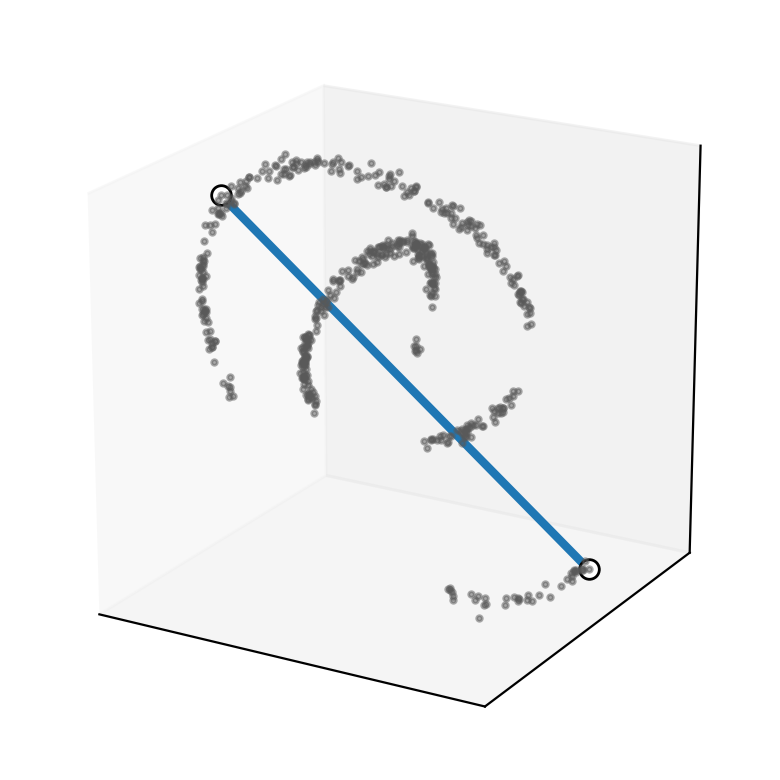

In [23]:
# -*- coding: utf-8 -*-
"""
Nuvem 3D em formato 'dois C' (espiral aberta) + caminho geodésico em grafo kNN
Requisitos: numpy, matplotlib, scipy, scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path

# ----------------------------
# 1) Gera uma espiral aberta e recorta dois setores (dois "C")
# ----------------------------
rng = np.random.default_rng(7)

# Espiral de Arquimedes em 3D (no plano XY com leve variação em Z)
n_total = 1600                          # total de amostras temporárias
t = rng.uniform(0.0, 4*np.pi, n_total)  # 2 voltas
a, b = 0.15, 0.10                       # raio base e passo da espiral
r = a + b * t
x = r * np.cos(t)
y = r * np.sin(t)
z = 0.10 * np.sin(1.3 * t)              # ondulação sutil em Z

# Seleciona dois setores angulares para formar dois "C"
# (ajuste os intervalos para abrir/fechar o "C")
ang = (np.arctan2(y, x) + 2*np.pi) % (2*np.pi)
mask1 = (ang > 0.25*np.pi) & (ang < 1.40*np.pi)     # primeiro C
mask2 = (ang > 1.75*np.pi) | (ang < 0.05*np.pi)     # segundo C (envolvente)
mask  = mask1 | mask2

pts = np.stack([x[mask], y[mask], z[mask]], axis=1)

# Subamostras para ficar mais esparso e com ruído leve
keep = rng.choice(len(pts), size=550, replace=False)
pts = pts[keep]
pts += rng.normal(scale=0.012, size=pts.shape)      # ruído leve

# Inclina no espaço para dar aparência 3D
R = np.array([[ 0.96,  0.00,  0.28],
              [ 0.10,  0.98, -0.15],
              [-0.27,  0.20,  0.94]])
pts = pts @ R.T

# ----------------------------
# 2) Grafo k-vizinhos ponderado por distância
# ----------------------------
k = 8  # vizinhos (menos que 10 para manter “caminhos” finos)
A = kneighbors_graph(pts, n_neighbors=k, mode='distance', include_self=False)
A = 0.5 * (A + A.T)  # simetriza

# ----------------------------
# 3) Escolhe dois nós distantes (extremos projetados)
# ----------------------------
# PCA 1D para pegar extremos
U, S, Vt = np.linalg.svd(pts - pts.mean(0), full_matrices=False)
proj = (pts - pts.mean(0)) @ Vt[0]
start = np.argmin(proj)
end   = np.argmax(proj)

# ----------------------------
# 4) Menor caminho geodésico (no grafo)
# ----------------------------
dist_row, predecessors = shortest_path(A, directed=False, indices=start,
                                       return_predecessors=True)
path = []
v = end
while v != -9999 and v != start:
    path.append(v)
    v = predecessors[v]
path.append(start)
path = path[::-1]
path_xyz = pts[path]

# ----------------------------
# 5) Plot 3D estilo da figura A
# ----------------------------
fig = plt.figure(figsize=(4, 8), dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Pontos: menores e mais esparsos
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=4, c='0.35', depthshade=False, alpha=0.5)

# Caminho geodésico (azul default do Matplotlib)
ax.plot(path_xyz[:,0], path_xyz[:,1], path_xyz[:,2], lw=3)

# Nós de início/fim
ax.scatter(*pts[start], s=50, edgecolor='k', facecolor='w', zorder=5)
ax.scatter(*pts[end],   s=50, edgecolor='k', facecolor='w', zorder=5)

# Aparência limpa
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_box_aspect([1, 1, 1])
ax.view_init(20, -60)

plt.tight_layout()
plt.show()

# Para salvar:
# plt.savefig("figura_A_duploC.png", dpi=300, bbox_inches="tight")
